In [2]:
import numpy as np
import Plot as plot
import math
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.offline as offline
import time
import datetime
import pickle
import os
import scipy.spatial
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib as plt
import logging
from scipy import signal
import learningAlgs as classImportLA
import dataManipulation as dataMan
from itertools import permutations
import importlib
from datetime import timedelta
from multiprocessing import Pool
import multiprocessing
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.cluster import KMeans
import timeIntervalPlotter as intervalPlotter
import pysal
import warnings
import lumping_traditional as oldLumping
import boundaryFull_SS_WeightedLumping as WLumping
from importlib import reload
from scipy.stats import rayleigh
import dataManipulation as dataMan
import matplotlib.pyplot as plt
import processData as processData
import tensorflow as tf
import random
from random import shuffle

warnings.filterwarnings('always')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Fetching Data and Creating Transition Matrix

In [27]:
dataFrame = processData.processingData()
#address is: /home/netlab/Desktop/thesis/data/1node1-3-5/
#/home/netlab/Desktop/thesis/data/500f80271400/
data = dataFrame.copy() #copying the dataFrame to have a copy of not edited data

data = processData.dataFrameManipulation(data)

the address of the collected data files (not alligned files or CSV files): /home/sepehr/thesis/data/500f80271400/
['500f80271400.txt']
here
500f80271400.txt is in csvChecker

we have the csv file: pulling out data

   col1                time  CU
0     0 2018-11-13 02:01:32  45
1     1 2018-11-13 02:01:38  45
2     2 2018-11-13 02:01:44  51
3     3 2018-11-13 02:01:50  53
4     4 2018-11-13 02:01:56  45
now we have the processed data from pandas
please enter how long would be the chunk minutes? 5
removing weekends from the data


In [29]:
data_cpy = data.copy()

In [42]:
data = data_cpy.copy()

In [43]:
pd.options.mode.chained_assignment = None
numberOfStates = 255
timeIndexCounter = 0
iteration = max(data["timeIndex"]) + 1
i = 0
boolean = 0

while i <= iteration:
    success = False
    j = i
    print("i is: ", i)
    while success != True:
        print("j is: ", j)
        data["timeIndex"].loc[data["timeIndex"] == j] = i
        data_partition = data.loc[data["timeIndex"] == i].copy()
        cuTrans_5min = processData.markovianTransitionMatrixDegree1(data_partition, numberOfStates, "CU")
        normalizedCuTrans_5min = processData.normalizingTransMatrix(cuTrans_5min)
        
        cuTrans_cpy = normalizedCuTrans_5min.copy()
        maximum = 0
        counter = 1
        for x in range(len(cuTrans_cpy[-1])):
            if int(np.sum(cuTrans_cpy[-1][x])) != 0:
                if (counter > maximum):
                    maximum = counter
                counter = 1
            elif int(np.sum(cuTrans_cpy[-1][x])) == 0 and int(np.sum(cuTrans_cpy[-1].T[x])) == 0:
                counter += 1
        if boolean == 1:
            i = iteration + 1
            break
        
        if j > iteration:
            j = i
            i -= 1
            boolean = 1
        
        if (max(maximum, counter)/255 * 100) > 25:
            j += 1
            print("bigger, so: j = ", j)
            continue
        else:
            i = j + 1
            success = True

i is:  0
j is:  0
bigger, so: j =  1
j is:  1
i is:  2
j is:  2
i is:  3
j is:  3
bigger, so: j =  4
j is:  4
bigger, so: j =  5
j is:  5
i is:  6
j is:  6
i is:  7
j is:  7
bigger, so: j =  8
j is:  8
bigger, so: j =  9
j is:  9
bigger, so: j =  10
j is:  10
bigger, so: j =  11
j is:  11
i is:  12
j is:  12
bigger, so: j =  13
j is:  13
bigger, so: j =  14
j is:  14
bigger, so: j =  15
j is:  15
bigger, so: j =  16
j is:  16
i is:  17
j is:  17
bigger, so: j =  18
j is:  18
bigger, so: j =  19
j is:  19
bigger, so: j =  20
j is:  20
bigger, so: j =  21
j is:  21
i is:  22
j is:  22
i is:  23
j is:  23
bigger, so: j =  24
j is:  24
bigger, so: j =  25
j is:  25
i is:  26
j is:  26
bigger, so: j =  27
j is:  27
i is:  28
j is:  28
bigger, so: j =  29
j is:  29
i is:  30
j is:  30
bigger, so: j =  31
j is:  31
bigger, so: j =  32
j is:  32
bigger, so: j =  33
j is:  33
i is:  34
j is:  34
i is:  35
j is:  35
bigger, so: j =  36
j is:  36
bigger, so: j =  37
j is:  37
i is:  38
j is:  38


In [64]:
data = data_cpy1.copy()

In [66]:
timeIndexVal = 0
unique_timeIndex = sorted(data["timeIndex"].unique())

for i in range(len(unique_timeIndex)):
    data["timeIndex"].loc[data["timeIndex"] == unique_timeIndex[i]] = timeIndexVal
    timeIndexVal += 1

In [67]:
len(sorted(data["timeIndex"].unique()))

195

# Calculating days and shuffling with seed to create Correlations

In [68]:
def dayCalculator(x):
    years = x["time"].year - data["time"][0].year
    months = x["time"].month - data["time"][0].month
    days = x["time"].day - data["time"][0].day
    return ((years*12*30) + (months*30) + days)
data["day"] = data.apply(lambda x: dayCalculator(x), axis = 1)

In [69]:
uniqueDays = []
uniqueDays.extend(data.apply(lambda x: x["day"] if x["day"] not in uniqueDays else np.inf, axis = 1))
uniqueDays = list(set(uniqueDays))
random.Random(0).shuffle(uniqueDays)

days30 = uniqueDays[0:30]
data_within_30Days = data.loc[data["day"].isin(days30)]

In [70]:
numberOfStates = 255
cuTrans_30Days = processData.markovianTransitionMatrixDegree1(data_within_30Days, numberOfStates, "CU")
normalizedCuTrans_30Days = processData.normalizingTransMatrix(cuTrans_30Days)

In [71]:
from scipy import signal
pd.options.mode.chained_assignment = None
steadyState_30days = np.zeros(shape=(normalizedCuTrans_30Days.shape[0],
                                     normalizedCuTrans_30Days.shape[1]))
for i in range(normalizedCuTrans_30Days.shape[0]):
    steadyState_30days[i] = abs(pysal.spatial_dynamics.ergodic.steady_state(normalizedCuTrans_30Days[i]))

In [73]:
max(data["timeIndex"])

194

# Calculating Correlations

In [74]:
for x in range(max(data["timeIndex"])+1):
    data["corr" + str(x + 1)] = np.inf

In [75]:
print(uniqueDays)
for j in uniqueDays:
    print(j)
    for i in range(max(data["timeIndex"])+1):
        data_correlation = data.loc[(data["timeIndex"] == i) & (data["day"] == j)].copy()
        if len(data_correlation) == 0:
            continue
        cuTran_corr = processData.markovianTransitionMatrixDegree1(data_correlation, numberOfStates, "CU")
        for x in range(cuTran_corr[-1].shape[0]):
            if np.sum(cuTran_corr[-1][x]) == 0:
                continue
            cuTran_corr[-1][x] = cuTran_corr[-1][x] / np.sum(cuTran_corr[-1][x])
        steadyState_corr = abs(pysal.spatial_dynamics.ergodic.steady_state(cuTran_corr[-1]))

        steadyState_corr_normalize = (steadyState_corr - np.mean(steadyState_corr)) / (
            np.std(steadyState_corr) * len(steadyState_corr))
        
        correlationDistance = []
        
        for x in range(max(data["timeIndex"])+1):
            ss_normalize = (steadyState_30days[x] - np.mean(steadyState_30days[x])) / (
                np.std(steadyState_30days[x]))
            data["corr" + str(x + 1)].loc[(data["timeIndex"] == i) & (data["day"] == j)] = signal.correlate(
                steadyState_corr_normalize, ss_normalize, mode="valid")[0]

[31, 10, 15, 9, 185, 17, 1, 252, 257, 195, 22, 205, 191, 167, 238, 2, 184, 246, 224, 210, 25, 8, 32, 14, 201, 147, 30, 146, 240, 161, 254, 236, 177, 264, 245, 141, 153, 219, 178, 18, 243, 216, 4, 28, 21, 29, 148, 223, 198, 211, 218, 189, 215, 35, 260, 183, 259, 0, 217, 154, 199, 253, 3, 258, 197, 251, 36, 164, 196, 250, 247, 202, 168, 11, 239, 163, 24, 225, 212, 149, 237, 16, 244, 160, 23, 208, 37, 222, 182, 203, 162, 190, 204, 209, 150, 7, 192, 188]
31
10
15
9
185
17
1
252
257
195
22
205
191
167
238
2
184
246
224
210
25
8
32
14
201
147
30
146
240
161
254
236
177
264
245
141
153
219
178
18
243
216
4
28
21
29
148
223
198
211
218
189
215
35
260
183
259
0
217
154
199
253
3
258
197
251
36
164
196
250
247
202
168
11
239
163
24
225
212
149
237
16
244
160
23
208
37
222
182
203
162
190
204
209
150
7
192
188


# Creating Staionary Process Values

In [76]:
copy_data = data.copy()
data["logDiff"] = np.inf
data["log"] = np.inf
data["normalLogDiff"] = np.inf

In [77]:
for i in range(np.max(data["timeIndex"]) + 1):
    dataTimeIndex = data.loc[data["timeIndex"] == i]
    dataTimeIndex["log"] = np.log(dataTimeIndex["CU"])
    dataTimeIndex = dataTimeIndex.loc[dataTimeIndex["log"] != -np.inf]
    dataTimeIndex = dataTimeIndex.loc[dataTimeIndex["log"] != np.inf]
    dataTimeIndex = dataTimeIndex.dropna()
    
    dataTimeIndex["logDiff"] = dataTimeIndex["log"].diff()
    dataTimeIndex = dataTimeIndex.loc[dataTimeIndex["logDiff"] != -np.inf]
    dataTimeIndex = dataTimeIndex.loc[dataTimeIndex["logDiff"] != -np.inf]
    dataTimeIndex = dataTimeIndex.dropna()
    
    dataTimeIndex["normalLogDiff"] = dataTimeIndex["logDiff"] / np.max(dataTimeIndex["logDiff"])
    data.loc[data["timeIndex"] == i] = dataTimeIndex
    
data = data.loc[data["log"] != np.inf]
data = data.loc[data["log"] != -np.inf]
data = data.dropna()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeW

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeW

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeW

# Writing Feature Engineered DataFrame into a Pickle

In [78]:
data["timeIndex"] = data["timeIndex"].astype(int)
data.to_pickle("flexible_featureEngineer.pickle")

In [79]:
data.head()

,col1,time,CU,CU/255,timeIndex,weekDay,day,corr1,corr2,corr3,...,corr189,corr190,corr191,corr192,corr193,corr194,corr195,logDiff,log,normalLogDiff
1,1.0,2018-11-12 19:01:38,45.0,0.176471,161,0.0,0.0,0.640855,0.647438,0.6741,...,0.695477,0.630518,0.642186,0.671536,0.687438,0.684162,0.688992,0.000000,3.806662,0.000000
2,2.0,2018-11-12 19:01:44,51.0,0.200000,161,0.0,0.0,0.640855,0.647438,0.6741,...,0.695477,0.630518,0.642186,0.671536,0.687438,0.684162,0.688992,0.125163,3.931826,0.086422
3,3.0,2018-11-12 19:01:50,53.0,0.207843,161,0.0,0.0,0.640855,0.647438,0.6741,...,0.695477,0.630518,0.642186,0.671536,0.687438,0.684162,0.688992,0.038466,3.970292,0.026560
4,4.0,2018-11-12 19:01:56,45.0,0.176471,161,0.0,0.0,0.640855,0.647438,0.6741,...,0.695477,0.630518,0.642186,0.671536,0.687438,0.684162,0.688992,-0.163629,3.806662,-0.112981
5,5.0,2018-11-12 19:02:02,45.0,0.176471,161,0.0,0.0,0.640855,0.647438,0.6741,...,0.695477,0.630518,0.642186,0.671536,0.687438,0.684162,0.688992,0.000000,3.806662,0.000000


In [80]:
data = pd.read_pickle("flexible_featureEngineer.pickle")

In [81]:
numberOfStates = 255
cuTrans = processData.markovianTransitionMatrixDegree1(data, numberOfStates, "CU")
normalizedCuTrans = processData.normalizingTransMatrix(cuTrans)

In [82]:
def preparingMatrixForLumping(transitionMatrix):
    reload(oldLumping)
    percentageMatrix_list = bandwidthPercentage(transitionMatrix)
    zero_cols_rows = []
    #*************removing zeros from columns and rows (matrix reduction) ****************
    for i in range(len(transitionMatrix)):
        if (np.sum(transitionMatrix[i]) == 0) and (np.sum(transitionMatrix[:,i]) == 0):
            zero_cols_rows.append(i)


    irreducible_matrix = transitionMatrix.copy()
    for i in range(len(zero_cols_rows) - 1, -1, -1):
        irreducible_matrix = np.delete(irreducible_matrix, zero_cols_rows[i], axis = 0)
        irreducible_matrix = np.delete(irreducible_matrix, zero_cols_rows[i], axis = 1)
        percentageMatrix_list[zero_cols_rows[i]][2] = True


    for i in range(len(percentageMatrix_list) - 1, 0, -1):
        if (percentageMatrix_list[i][2] == True) and (percentageMatrix_list[i - 1][2] == True):
            percentageMatrix_list[i - 1][0].extend(percentageMatrix_list[i][0])
            percentageMatrix_list[i - 1][1] = percentageMatrix_list[i][1]
            del percentageMatrix_list[i]

    for i in range(len(irreducible_matrix)):
        if np.sum(irreducible_matrix[i], dtype = np.float32) != 1.0:
            print(np.sum(irreducible_matrix[i], dtype = np.float32))

    return percentageMatrix_list, irreducible_matrix

def bandwidthPercentage(vectorMatrix):
    percentageIncreament = (100 / vectorMatrix.shape[0])
    percentageMatrix = []
    maxPercentage = 0
    for j in range(vectorMatrix.shape[0]):
        maxPercentage += percentageIncreament
        percentageMatrix.append([[j], maxPercentage, False])

    return percentageMatrix

In [83]:
reload(oldLumping)

<module 'lumping_traditional' from '/home/sepehr/thesis/APDataML/lumping_traditional.py'>

In [84]:
normalizedCuTrans.shape

(195, 255, 255)

In [85]:
for i in range((max(data["timeIndex"]) + 1)):
    percentageMatrix_list, irreducible_matrix = preparingMatrixForLumping(normalizedCuTrans[i])
    result = oldLumping.lumping(irreducible_matrix, percentageMatrix_list, False)
    nameResult = "/home/sepehr/thesis/APDataML/pickles/4normal_25-10_lumping_flexible_result_" + str(i) + ".pickle"
    with open(nameResult, 'wb') as handle:
        pickle.dump(result, handle)
    namePercent = "/home/sepehr/thesis/APDataML/pickles/4normal_25-10_lumping_flexible_percentage_" + str(i) + ".pickle"
    with open(namePercent, 'wb') as handle:
        pickle.dump(percentageMatrix_list, handle)

0.99999994
0.99999994
1.0000001
we have these many sectors to check:  3250
0.99999994
0.99999994
0.99999994
we have these many sectors to check:  286
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
1.0000001
we have these many sectors to check:  447
1.0000001
0.99999994
1.0000001
we have these many sectors to check:  3415
0.99999994
0.99999994
0.99999994
0.9999999
0.99999994
0.99999994
we have these many sectors to check:  787
0.99999994
1.0000001
0.99999994
0.99999994
we have these many sectors to check:  780
0.99999994
0.99999994
1.0000001
0.99999994
we have these many sectors to check:  264
0.99999994
0.9999999
0.99999994
we have these many sectors to check:  112
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
we have these many sectors to check:  130
0.99999994
0.99999994
1.0000001
we have these many sectors to check:  140
1.0000001
0.99999994
0.99999994
0.99999994
1.0000001
we have these many sectors to check:  5
0.99999994
0.99999994
1.0000001
we have these many sec

we have these many sectors to check:  250845
1.0000001
0.99999994
0.99999994
0.99999994
1.0000001
0.99999994
0.99999994
1.0000001
1.0000001
1.0000001
1.0000001
we have these many sectors to check:  236122
0.99999994
1.0000001
0.99999994
0.99999994
0.99999994
0.99999994
1.0000001
1.0000001
we have these many sectors to check:  111198
0.9999999
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
1.0000001
we have these many sectors to check:  53051
0.99999994
0.99999994
0.99999994
we have these many sectors to check:  130392
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
1.0000001
1.0000001
1.0000001
we have these many sectors to check:  125202
0.9999999
0.99999994
0.9999999
0.99999994
0.99999994
1.0000001
we have these many sectors to check:  195654
0.99999994
1.0000001
0.99999994
0.99999994
we have these many sectors to check:  258374
0.99999994
0.99999994
1.0000001
we have these many sectors to check:  212492
1.0000001
0.99999994
1.0000001
0.9999999
0.99999994
1.

0.99999994
0.99999994
1.0000001
we have these many sectors to check:  168904
1.0000001
1.0000001
1.0000001
we have these many sectors to check:  90343
0.99999994
0.99999994
1.0000001
1.0000001
we have these many sectors to check:  75979
0.99999994
0.99999994
0.99999994
0.99999994
1.0000001
0.99999994
we have these many sectors to check:  30286
0.99999994
0.99999994
we have these many sectors to check:  98238
0.99999994
1.0000001
0.99999994
1.0000001
0.99999994
0.99999994
1.0000001
1.0000001
we have these many sectors to check:  149887
0.99999994
1.0000001
we have these many sectors to check:  77970
0.99999994
0.99999994
1.0000001
1.0000001
we have these many sectors to check:  73113
0.99999994
0.9999999
0.99999994
1.0000001
we have these many sectors to check:  90710
1.0000001
0.99999994
1.0000001
1.0000001
1.0000001
we have these many sectors to check:  21745
0.99999994
0.99999994
1.0000001
0.99999994
1.0000001
we have these many sectors to check:  14630
0.99999994
0.99999994
we have 

In [86]:
reload(oldLumping)

<module 'lumping_traditional' from '/home/sepehr/thesis/APDataML/lumping_traditional.py'>

In [87]:
for i in range((max(data["timeIndex"]) + 1)):
    percentageMatrix_list, irreducible_matrix = preparingMatrixForLumping(normalizedCuTrans[i])
    result = oldLumping.lumping(irreducible_matrix, percentageMatrix_list, False)
    nameResult = "/home/sepehr/thesis/APDataML/pickles/4normal_25-10_lumping_flexible_result_" + str(i) + ".pickle"
    with open(nameResult, 'wb') as handle:
        pickle.dump(result, handle)
    namePercent = "/home/sepehr/thesis/APDataML/pickles/4normal_25-10_lumping_flexible_percentage_" + str(i) + ".pickle"
    with open(namePercent, 'wb') as handle:
        pickle.dump(percentageMatrix_list, handle)

0.99999994
0.99999994
1.0000001
we have these many sectors to check:  75220
0.99999994
0.99999994
0.99999994
we have these many sectors to check:  12966
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
1.0000001
we have these many sectors to check:  9388
1.0000001
0.99999994
1.0000001
we have these many sectors to check:  43218
0.99999994
0.99999994
0.99999994
0.9999999
0.99999994
0.99999994
we have these many sectors to check:  4739
0.99999994
1.0000001
0.99999994
0.99999994
we have these many sectors to check:  4474
0.99999994
0.99999994
1.0000001
0.99999994
we have these many sectors to check:  1932
0.99999994
0.9999999
0.99999994
we have these many sectors to check:  3055
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
we have these many sectors to check:  5380
0.99999994
0.99999994
1.0000001
we have these many sectors to check:  3008
1.0000001
0.99999994
0.99999994
0.99999994
1.0000001
we have these many sectors to check:  926
0.99999994
0.99999994
1.0000001
we have t

we have these many sectors to check:  250845
1.0000001
0.99999994
0.99999994
0.99999994
1.0000001
0.99999994
0.99999994
1.0000001
1.0000001
1.0000001
1.0000001
we have these many sectors to check:  236122
0.99999994
1.0000001
0.99999994
0.99999994
0.99999994
0.99999994
1.0000001
1.0000001
we have these many sectors to check:  111198
0.9999999
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
1.0000001
we have these many sectors to check:  53051
0.99999994
0.99999994
0.99999994
we have these many sectors to check:  130392
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
1.0000001
1.0000001
1.0000001
we have these many sectors to check:  125202
0.9999999
0.99999994
0.9999999
0.99999994
0.99999994
1.0000001
we have these many sectors to check:  195654
0.99999994
1.0000001
0.99999994
0.99999994
we have these many sectors to check:  258374
0.99999994
0.99999994
1.0000001
we have these many sectors to check:  212492
1.0000001
0.99999994
1.0000001
0.9999999
0.99999994
1.

0.99999994
0.99999994
1.0000001
we have these many sectors to check:  168904
1.0000001
1.0000001
1.0000001
we have these many sectors to check:  90343
0.99999994
0.99999994
1.0000001
1.0000001
we have these many sectors to check:  75979
0.99999994
0.99999994
0.99999994
0.99999994
1.0000001
0.99999994
we have these many sectors to check:  30286
0.99999994
0.99999994
we have these many sectors to check:  98238
0.99999994
1.0000001
0.99999994
1.0000001
0.99999994
0.99999994
1.0000001
1.0000001
we have these many sectors to check:  149887
0.99999994
1.0000001
we have these many sectors to check:  77970
0.99999994
0.99999994
1.0000001
1.0000001
we have these many sectors to check:  73113
0.99999994
0.9999999
0.99999994
1.0000001
we have these many sectors to check:  90710
1.0000001
0.99999994
1.0000001
1.0000001
1.0000001
we have these many sectors to check:  21745
0.99999994
0.99999994
1.0000001
0.99999994
1.0000001
we have these many sectors to check:  14630
0.99999994
0.99999994
we have 

In [28]:
arrayOfLumpes = []
indexesOfCandidates = [[] for i in range((max(data["timeIndex"]) + 1))]
for timeIndex in range((max(data["timeIndex"]) + 1)):
    print(timeIndex)
    name = "/home/sepehr/thesis/APDataML/pickles/5normal_25-10_lumping_10min_result_" + str(timeIndex) + ".pickle"
    with open(name, 'rb') as handle:
        b = pickle.load(handle)
    
    if len(b) > 0:
        minDegree = np.inf        
        for i in range(len(b)):
            if b[i][0] < minDegree:
                minDegree = b[i][0]

        minError = np.inf
        for i in range(len(b)):
            if b[i][0] == minDegree and b[i][1] < minError:
                minError = b[i][1]

        for i in range(len(b)):
            if b[i][0] == minDegree and b[i][1] == minError:
                indexesOfCandidates[timeIndex].append(b[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143


In [29]:
name = "/home/sepehr/thesis/APDataML/pickles/5normal_25-10_lumping_10min.pickle"
with open(name, 'wb') as handle:
    pickle.dump(indexesOfCandidates, handle) 

In [30]:
def classifying(CU, boundaries):
    occupiedBandwidth = (CU / 255) * 100
    for i in range(len(boundaries)):
        if occupiedBandwidth <= boundaries[i]:
            return i
        
def dataPreparation(data, timeIndexes, minuteSplit, boundaries):
    from sklearn.utils import shuffle
    warnings.filterwarnings('always')
    reg = "l2"
    solvers = "lbfgs"
    clf = LogisticRegression(penalty = reg, max_iter = 100000, random_state = 0,
                             solver = solvers , multi_class = 'multinomial')
    accuracyValue = 0
    numOfElements = 0
    f1scoreValue = 0
    precisionValue = 0
    recallValue = 0
    prevRowTrain = np.inf
    prevCU = np.inf

    sampleIntervals = 6 #seconds
    minuteSplit = 30 #minutes
    numOfSamples = minuteSplit * 60 / sampleIntervals
    # numberOfDays = len(numOfDays)
    days = np.zeros(7)
    numOfThirtyMinsPerDay = np.zeros(int((24 * 60) / minuteSplit)) #in this case 48
#     which6SecondsPerPeriod = np.zeros(int(minuteSplit * 60 / sampleIntervals)) #in this case 300
    prevRowTrain = np.inf
    prevCU = np.inf

    XArraysForLearning = []
    YArraysForLearning = []
    XArraysForTesting = []
    YArraysForTesting = []

    x = timeIndexes
    wholeDataFrame = data.loc[(data["timeIndex"] == x)].copy()
    
    wholeDataFrame["cuClass"] = wholeDataFrame["CU"].apply(lambda x: classifying(x, boundaries))

    

    stackCounter = 0
    prevCU = 0
    prev2CU = 0
    prev3CU = 0
    prev4CU = 0
    prev5CU = 0
    print("start training set generation")
    #number of features are: prevCU + 48 correlations + 1 logDiff
    numberOfFeatures = len(boundaries) + 48 + 1 
    
    XArraysForLearning = np.zeros(shape=(len(wholeDataFrame), numberOfFeatures))
    YArraysForLearning = np.zeros(shape=(len(wholeDataFrame), len(boundaries)))
#     print(len(trainingDataFrame))
    counter = 0
    pandasIndexCounter = 0
    for index, row in wholeDataFrame.iterrows():
        XArraysForLearning[pandasIndexCounter, prevCU] = 1
        for corrs in range(48):
            XArraysForLearning[pandasIndexCounter, len(boundaries) + corrs] = row["corr" + str(corrs + 1)]

        XArraysForLearning[pandasIndexCounter, len(boundaries) + 48] = row["normalLogDiff"]
        YArraysForLearning[pandasIndexCounter, row["cuClass"]] = 1
#         print(XArraysForLearning[pandasIndexCounter])

        which6SecondsPerPeriod = 0
    
        prevCU = row["cuClass"]
        pandasIndexCounter += 1

    XArraysForLearning, YArraysForLearning = shuffle(XArraysForLearning, YArraysForLearning, random_state=0)
    XArraysForTraining = XArraysForLearning[:int(0.8*len(XArraysForLearning))]
    YArraysForTraining = YArraysForLearning[:int(0.8*len(YArraysForLearning))]
    XArraysForTesting = XArraysForLearning[int(0.8*len(XArraysForLearning)):]
    YArraysForTesting = YArraysForLearning[int(0.8*len(YArraysForLearning)):]
    print(XArraysForTraining.shape[0])
    print(XArraysForTesting.shape[0])


    return XArraysForTraining, YArraysForTraining, XArraysForTesting, YArraysForTesting, boundaries

def tensorFlowLossFunction(
    lossFuncBool, XArraysForLearning, YArraysForLearning, XArraysForTesting, YArraysForTesting, boundaries):
    
    batch_size = 64
    learning_rate = 0.01
    beta = 0.1
    numOfEpochs = 5000
    graph = tf.Graph()
    with graph.as_default():
        x = tf.placeholder(tf.float32, shape = (batch_size, XArraysForLearning.shape[1]))
        y_ = tf.placeholder(tf.float32, shape = (batch_size, YArraysForLearning.shape[1]))
#         print(weights.dtype)
#         print(weights.shape)
#         print(XArraysForLearning.shape[1], YArraysForLearning.shape[1])
#         multiDistrib = np.vstack((mult, mult))
#         for i in range(batch_size - 2):
#             multiDistrib = np.vstack((multiDistrib, mult))
        W = tf.Variable(tf.truncated_normal([XArraysForLearning.shape[1], YArraysForLearning.shape[1]], seed = 0), name="weights", dtype=tf.float32)
        b = tf.Variable(tf.truncated_normal([YArraysForLearning.shape[1]], seed = 0), dtype=tf.float32)

        tf_test_dataset64 = tf.constant(XArraysForTesting)
        tf_test_dataset = tf.cast(tf_test_dataset64, tf.float32)


        beta = 0.05
        logits = tf.matmul(x, W)
        train_prediction = tf.nn.softmax(logits)
        # train_prediction = tf.nn.softmax_cross_entropy_with_logits_v2(labels = y_, logits = logits)
        test_prediction = tf.nn.softmax(tf.add(tf.matmul(tf_test_dataset, W),b))

        # x = XArraysForLearning[0:(0 + batch_size), :]
        # y_ = tf.Variable(YArraysForLearning[0:(0 + batch_size), :])

        # loss = assymetricLossFunction(train_prediction, y_, boundaries)
        # loss = assymetricLossFunction(train_prediction, y_, boundaries)
        
        if lossFuncBool == 0:
            loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = y_)
        
        elif lossFuncBool == 1:
            loss = assymetricLossFunction(train_prediction, y_, boundaries)
#         dist = tfp.distributions.Multinomial(total_count=1, logits=logits)
#         loss = loss - (dist.log_prob(mult))
        # regularizer = tf.nn.l2_loss(W)
        # loss = tf.reduce_mean(loss + beta * regularizer)
        # loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits = train_prediction, labels = y_)
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

        prevAcc = 0
        prevLoss = np.inf

    with tf.Session(graph=graph) as session:
        initializer = tf.contrib.layers.xavier_initializer()
        tf.set_random_seed(0)
        W = tf.Variable(initializer([XArraysForLearning.shape[1], YArraysForLearning.shape[1]]))
        b = tf.Variable(initializer([YArraysForLearning.shape[1]]))       
        tf.global_variables_initializer().run()
#         print(W.eval())
        
        print("Initialized")

        numberOfBatchIteration = int(XArraysForLearning.shape[0] / batch_size)
        restOfData = XArraysForLearning.shape[0] % batch_size
        if restOfData != 0:
            numberOfBatchIteration += 1

        accuracy_result = 0
        accuracy_earlyStop = 0
        earlyStoppingCounter = 0
        
        for epoch in range(numOfEpochs):
            accuracyValue = 0
            lossValue = 0
            totalBatch = 0
            i = 0
            randomize = np.arange(XArraysForLearning.shape[0])
            random.Random(epoch).shuffle(randomize)
            XArraysForLearning = XArraysForLearning[randomize]
            YArraysForLearning = YArraysForLearning[randomize]

            for iteration in range(numberOfBatchIteration):
                if (iteration == numberOfBatchIteration - 1) and restOfData != 0:
                    break
                    batch_data = XArraysForLearning[i:, :]
                    batch_labels = YArraysForLearning[i:, :]

                else:
                    batch_data = XArraysForLearning[i:(i + batch_size), :]
                    batch_labels = YArraysForLearning[i:(i + batch_size), :]

                    i += batch_size


                feed_dict = {x : batch_data, y_ : batch_labels}
                _, predictions, l = session.run([optimizer, train_prediction, loss], feed_dict=feed_dict)

#                 print(l)
                lossValue *= (iteration)
                lossValue += (np.sum(l))
                lossValue /= (iteration + 1)
                totalBatch += batch_size
                # print(accuracy(batch_data, batch_labels))
                
                accuracyValue += accuracy(predictions, batch_labels) * batch_size


            totalAccuracy = accuracyValue/totalBatch
#             print(session.run(W))
#             test_result = test_prediction.eval()
            if epoch % 20 == 0:
                print("epoch ", epoch, totalAccuracy, lossValue)
                
            if lossValue > prevLoss and earlyStoppingCounter == 50:
                break

            elif lossValue > prevLoss:
                earlyStoppingCounter += 1

            elif lossValue <= prevLoss:
                prevLoss = lossValue
                earlyStoppingCounter = 0
#             print(lossValue, prevLoss)
                
            



        # print(session.run(W))
        predictionResult = test_prediction.eval()
        accResult = accuracy(predictionResult , YArraysForTesting)
        penaltyValue = assymetricPredictionScore(predictionResult, YArraysForTesting, boundaries)
#         print(W.eval())
        accuracy_result = accResult
            
        correctLableIndex = np.argmax(YArraysForTesting, 1)
        predictionIndex = np.argmax(predictionResult, 1)
        
        precision = precision_score(correctLableIndex, predictionIndex, average='weighted')
        recall = recall_score(correctLableIndex, predictionIndex, average='weighted')
        f1Score = f1_score(correctLableIndex, predictionIndex, average='weighted')            
        
        return accuracy_result, penaltyValue, precision, recall, f1Score

            
    
def assymetricPredictionScore(predictedLables, trueLables, boundaries):
    xAxisPoints = np.linspace(rayleigh.ppf(0.01), rayleigh.ppf(0.99), 338)
    #number of overal datapoints must stay the same all the time
    maxState = 338

    inverseDistrib = max(rayleigh.pdf(xAxisPoints)) - rayleigh.pdf(xAxisPoints)
    minState = np.argmin(inverseDistrib)

    underUtilizedSum = 0
    overUtilizedSum = 0
    numberOfUnderUtilizedStates = minState - 0
    numberOfOverUtilizedStates = maxState - minState

    xAxisPoints -= xAxisPoints[np.argmin(inverseDistrib)]

    underUtilVal = numberOfUnderUtilizedStates / 100
    overUtilVal = numberOfOverUtilizedStates / 100

    correctLableIndex = np.argmax(trueLables, 1)
    predictionIndex = np.argmax(predictedLables, 1)

    diffPercentage = np.zeros(shape = (predictedLables.shape))

    penalties = np.zeros(shape = (predictedLables.shape))

    for index in range(predictedLables.shape[0]):
        diffPercentage[index] = boundaries[correctLableIndex[index]] - boundaries[:]


    for i in range(diffPercentage.shape[0]):
        for j in range(diffPercentage.shape[1]):
            if diffPercentage[i][j] > 0:
                penalties[i][j] = inverseDistrib[minState + math.floor
                                                  (diffPercentage[i][j] * overUtilVal)]
            else:
                penalties[i][j] = inverseDistrib[minState + math.floor
                                                  (diffPercentage[i][j] * underUtilVal)]

    sumOfPenalty = 0
    for i in range(predictionIndex.shape[0]):
        sumOfPenalty += penalties[i][predictionIndex[i]]

    return sumOfPenalty
    
    
def accuracy(predictedLables, trueLables):
    import sys
    np.set_printoptions(threshold=sys.maxsize)
    correctLableIndex = np.argmax(trueLables, 1)
    predictionIndex = np.argmax(predictedLables, 1)
    errors = [0 for i in range(trueLables.shape[1])]
    corrects = [0 for i in range(trueLables.shape[1])]
    for i in range(len(correctLableIndex)):
        if correctLableIndex[i] != predictionIndex[i]:
            errors[correctLableIndex[i]] += 1
            corrects[predictionIndex[i]] += 1

    acc = np.float64(np.sum(correctLableIndex == predictionIndex)/predictedLables.shape[0])
    return acc
    
    
def assymetricLossFunction(prediction, correctLable, boundaries):
    xAxisPoints = np.linspace(rayleigh.ppf(0.01), rayleigh.ppf(0.99), 338)
    #number of overal datapoints must stay the same all the time
    maxState = 338
    inverseDistrib = max(rayleigh.pdf(xAxisPoints)) - rayleigh.pdf(xAxisPoints)
    inverseDistrib = tf.constant(inverseDistrib)
    xAxisPoints -= xAxisPoints[np.argmin(inverseDistrib)]
    minState = np.argmin(inverseDistrib)
    numberOfOverUtilizedStates = maxState - minState
    numberOfUnderUtilizedStates = minState
    minState = tf.constant(minState, tf.float32)
    numberOfOverUtilizedStates = tf.constant(numberOfOverUtilizedStates, tf.float32)
    numberOfUnderUtilizedStates = tf.constant(numberOfUnderUtilizedStates, tf.float32)

    underUtilVal = numberOfUnderUtilizedStates / 100
    overUtilVal = numberOfOverUtilizedStates / 100


    boundaries = tf.constant(boundaries, tf.float32)
    correctLableIndex = tf.argmax(correctLable, 1)

    diffPercentage = []
    for index in range(correctLableIndex.shape[0]):
        diffPercentage.append(boundaries[correctLableIndex[index]] - boundaries[:])

    diffPercentage = tf.stack(diffPercentage)

    penalties = []

    counter = 0
    for i in range(diffPercentage.shape[0]):
        for j in range(diffPercentage.shape[1]):
            counter += 1

            penalties.append(tf.cond(
                    tf.greater(diffPercentage[i][j], 0),
                    lambda: inverseDistrib[tf.dtypes.cast(minState + tf.math.floor
                                                                   (tf.math.scalar_mul(diffPercentage[i][j],
                                                                                       overUtilVal)), tf.int32)],
                    lambda: inverseDistrib[tf.dtypes.cast(minState + tf.math.floor
                                                                   (tf.math.scalar_mul
                                                                    (diffPercentage[i][j], underUtilVal))
                                                                   , tf.int32)]
                    ))

    penalties = tf.stack(penalties)
    penalties = tf.dtypes.cast(penalties, tf.float32)
    penalties = tf.reshape(penalties, diffPercentage.shape)
    penalties = penalties / tf.norm(penalties)

    # weights = tf.reduce_sum(penalties * (1-prediction), axis=1)
    weights = (1 - penalties) * prediction
    weights = weights / tf.norm(weights)
    # print(correctLable)
    # print(prediction)
    # print(penalties)
    loss = tf.losses.softmax_cross_entropy(onehot_labels = correctLable, logits = weights)
    # weighted_losses = tf.nn.softmax_cross_entropy_with_logits_v2(labels = penalties, logits = prediction)
    # loss = tf.reduce_sum(weighted_losses)
    # loss = tf.reduce_sum(penalties * prediction)
    return tf.reduce_mean(loss)

In [33]:
cuTran_cpy = normalizedCuTrans_10min.copy()

In [36]:
name = "/home/sepehr/thesis/APDataML/pickles/5normal_25-10_lumping_10min.pickle"
with open(name, 'rb') as handle:
    normalLumping = pickle.load(handle)

In [37]:
percentageArray = []
for i in range(len(normalLumping)):
    name = "/home/sepehr/thesis/APDataML/pickles/5normal_25-10_lumping_10min_percentage_" + str(i) + ".pickle"
    with open(name, 'rb') as handle:
        percentageArray.append(pickle.load(handle))

In [40]:
accuracyResult = [np.inf for i in range(len(normalLumping))]
penaltyResult = [np.inf for i in range(len(normalLumping))]
precisionResult = [np.inf for i in range(len(normalLumping))]
recallResult = [np.inf for i in range(len(normalLumping))]
f1ScoreResult = [np.inf for i in range(len(normalLumping))]
boundariesResult = [np.inf for i in range(len(normalLumping))]
lumpAproxResult = [np.inf for i in range(len(normalLumping))]
lumpErrorResult = [np.inf for i in range(len(normalLumping))]


testDataFrame = {"accuracy": accuracyResult, "penalty": penaltyResult, "precision": precisionResult, 
                 "recall": recallResult, "f1Score": f1ScoreResult, "boundaries": boundariesResult, 
                 "lumpAprox": lumpAproxResult, "lumpError": lumpErrorResult}

result_25_10_6class_10min_DataFrameNoPenalty = pd.DataFrame(testDataFrame)
result_25_10_6class_10min_DataFrameNoPenalty = result_25_10_6class_10min_DataFrameNoPenalty.astype('object')

result_25_10_6class_10min_DataFrameNoPenalty = pd.DataFrame(testDataFrame)
result_25_10_6class_10min_DataFrameNoPenalty = result_25_10_6class_10min_DataFrameNoPenalty.astype('object')

In [41]:
warnings.filterwarnings('ignore')
for timeIndex in range(len(normalLumping)):
    if len(normalLumping[timeIndex]) == 0:
        continue
    
    print(timeIndex)
    boundaries = np.array([])
    for i in range(1, len(normalLumping[0][0][3])):
        bound = normalLumping[timeIndex][0][3][i] + 1
        counter = 0
        for j in range(len(percentageArray[timeIndex])):
            if percentageArray[timeIndex][j][2] == False:
                counter += 1
            if counter == bound:
                boundaries = np.append(boundaries, percentageArray[timeIndex][j][1])
                break
    boundaries = np.append(boundaries,100)
    print(boundaries)
    
    XArraysForLearning, YArraysForLearning, XArraysForTesting, YArraysForTesting, boundaries = dataPreparation(
        data, timeIndex, 30, boundaries)

    print("starting tensor")
    lossFunctionBoolean = 0
    accuracy_result, penaltyValue, precision, recall, f1Score = tensorFlowLossFunction(
        lossFunctionBoolean, XArraysForLearning, YArraysForLearning, XArraysForTesting, 
        YArraysForTesting, boundaries)
    
    result_25_10_6class_10min_DataFrameNoPenalty.loc[timeIndex]["accuracy"] = accuracy_result
    result_25_10_6class_10min_DataFrameNoPenalty.loc[timeIndex]["penalty"] = penaltyValue
    result_25_10_6class_10min_DataFrameNoPenalty.loc[timeIndex]["precision"] = precision
    result_25_10_6class_10min_DataFrameNoPenalty.loc[timeIndex]["recall"] = recall
    result_25_10_6class_10min_DataFrameNoPenalty.loc[timeIndex]["f1Score"] = f1Score
    result_25_10_6class_10min_DataFrameNoPenalty.loc[timeIndex]["boundaries"] = boundaries
    result_25_10_6class_10min_DataFrameNoPenalty.loc[timeIndex]["lumpAprox"] = normalLumping[timeIndex][0][0]
    result_25_10_6class_10min_DataFrameNoPenalty.loc[timeIndex]["lumpError"] = normalLumping[timeIndex][0][1]

    

0
[ 10.19607843  33.33333333  51.37254902  64.31372549  89.01960784
 100.        ]
start training set generation
6358
1590
starting tensor
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Initialized
epoch  0 0.7498421717171717 46.357354193022765
epoch  20 0.928030303030303 12.165699178522283
epoch  40 0.931344696969697 11.109028214156023
epoch  60 0.9330808080808081 10.67644419573774
epoch  80 0.9340277777777778 10.514834733924475
epoch  100 0.9365530303030303 10.319865130414867
epoch  120 0.9330808080808081 10.3710156594864
epoch  140 0.936395202020202 10.036736912197533
epoch  160 0.9346590909090909 10.193851846637155
epoch  180 0.9362373737373737 10.05315589423132
epoch  2

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



start training set generation
6385
1597
starting tensor
Initialized
epoch  0 0.7457386363636364 47.191528879030784
epoch  20 0.9308712121212122 12.275921183403092
epoch  40 0.9326073232323232 10.993698226081001
epoch  60 0.9354482323232324 10.703517706707272
epoch  80 0.9360795454545454 10.458130258502386
epoch  100 0.9367108585858586 10.238615394842745
epoch  120 0.9373421717171717 10.075045780702073
epoch  140 0.9368686868686869 10.002646597948937
epoch  160 0.9387626262626263 9.954265897924252
epoch  180 0.9398674242424242 9.956888177178124
epoch  200 0.9384469696969697 9.807942094224867
epoch  220 0.9371843434343434 9.868075045672327


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



2
[ 11.37254902  36.07843137  51.37254902  66.2745098   83.1372549
 100.        ]
start training set generation
6329
1583
starting tensor
Initialized
epoch  0 0.7232142857142857 46.961481756093534
epoch  20 0.9145408163265306 12.993453127997261
epoch  40 0.9239477040816326 12.182157932495585
epoch  60 0.9213966836734694 11.869858673640657
epoch  80 0.9249043367346939 11.507277605484939
epoch  100 0.9257015306122449 11.431847557729604
epoch  120 0.9261798469387755 11.268434193669533
epoch  140 0.9241071428571429 11.360202302738111
epoch  160 0.9258609693877551 11.19516597961893
epoch  180 0.9237882653061225 11.135034488171952
epoch  200 0.9274553571428571 11.042594277128886
epoch  220 0.9261798469387755 10.993296812991705
epoch  240 0.9268176020408163 10.901579367871188
epoch  260 0.9239477040816326 10.97258571945891
epoch  280 0.9308035714285714 10.849799175651706
epoch  300 0.9287308673469388 10.789317169967967
epoch  320 0.9261798469387755 10.836986877480332
epoch  340 0.928890306122

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



11
[ 12.15686275  22.35294118  47.05882353  61.17647059  85.09803922
 100.        ]
start training set generation
6179
1545
starting tensor
Initialized
epoch  0 0.6219075520833334 64.72931502262749
epoch  20 0.8717447916666666 20.3584500849247
epoch  40 0.8863932291666666 18.378670498728763
epoch  60 0.88671875 17.96574675043424
epoch  80 0.8878580729166666 17.30942061543465
epoch  100 0.8889973958333334 17.14960320790609
epoch  120 0.8912760416666666 16.994321023424458
epoch  140 0.8896484375 16.919469798604638
epoch  160 0.8888346354166666 16.826678494612356
epoch  180 0.888671875 16.697664221127827
epoch  200 0.8875325520833334 16.742048069834716
epoch  220 0.8844401041666666 16.702151248852413
epoch  240 0.8902994791666666 16.533350611726444
epoch  260 0.89013671875 16.46828052401542
epoch  280 0.8888346354166666 16.450181931257255
epoch  300 0.88916015625 16.501074333985652
epoch  320 0.89013671875 16.52424428860346
epoch  340 0.8893229166666666 16.433621774117164


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



12
[ 17.25490196  39.21568627  50.19607843  63.1372549   82.35294118
 100.        ]
start training set generation
6204
1551
starting tensor
Initialized
epoch  0 0.6516927083333334 54.4169802069664
epoch  20 0.8782552083333334 18.685671597719193
epoch  40 0.8818359375 17.917978952328365
epoch  60 0.8811848958333334 17.65853121876717
epoch  80 0.88623046875 17.19504447778067
epoch  100 0.8819986979166666 17.321233292420708
epoch  120 0.8850911458333334 17.00338509678841
epoch  140 0.88623046875 16.82877712945143
epoch  160 0.8819986979166666 17.14067205289999
epoch  180 0.880859375 17.09670319656532
epoch  200 0.8841145833333334 16.76715716719626
epoch  220 0.8849283854166666 16.908544192711506
epoch  240 0.88525390625 16.85751616954802
epoch  260 0.8834635416666666 17.085666835308075
epoch  280 0.8837890625 17.283680220445
epoch  300 0.8844401041666666 16.856552198529254
epoch  320 0.8834635416666666 17.046724299589787
epoch  340 0.8875325520833334 16.65922958652178


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



13
[ 10.19607843  34.11764706  51.37254902  62.35294118  86.2745098
 100.        ]
start training set generation
6304
1577
starting tensor
Initialized
epoch  0 0.7605229591836735 43.9416339543401
epoch  20 0.9341517857142857 11.854924068158988
epoch  40 0.9325573979591837 11.004135574613299
epoch  60 0.9347895408163265 10.769697130942829
epoch  80 0.9367028061224489 10.435664279120308
epoch  100 0.9376594387755102 10.303100838953135
epoch  120 0.9376594387755102 10.206444565130736
epoch  140 0.9351084183673469 10.27975109888583
epoch  160 0.9354272959183674 10.442388833785543
epoch  180 0.9384566326530612 10.308901713818921
epoch  200 0.9376594387755102 10.044508274720641
epoch  220 0.9403698979591837 10.038453330799017
epoch  240 0.9387755102040817 9.994284931494263
epoch  260 0.9389349489795918 9.937084095818653
epoch  280 0.9427614795918368 9.83554322378976
epoch  300 0.9382971938775511 9.975653239658904
epoch  320 0.9400510204081632 9.969438732886802
14
[ 10.19607843  31.37254902  

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



17
[ 24.31372549  45.09803922  56.07843137  68.23529412  83.1372549
 100.        ]
start training set generation
6119
1530
starting tensor
Initialized
epoch  0 0.8858552631578948 26.992940109654477
epoch  20 0.9646381578947368 6.24807915687561
epoch  40 0.9646381578947368 5.8125348291899
epoch  60 0.9661184210526316 5.686887636937591
epoch  80 0.9649671052631579 5.584788953003132
epoch  100 0.9633223684210527 5.718667627008338
epoch  120 0.9659539473684211 5.586855333729794
epoch  140 0.9652960526315789 5.445516439488057
epoch  160 0.9643092105263158 5.555609420726173


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



23
[ 10.19607843  25.09803922  44.31372549  56.07843137  77.25490196
 100.        ]
start training set generation
6216
1555
starting tensor
Initialized
epoch  0 0.7211662371134021 50.61455659768018
epoch  20 0.9170425257731959 14.455090208151907
epoch  40 0.9228414948453608 13.06939863912838
epoch  60 0.9209085051546392 12.712354674781716
epoch  80 0.9215528350515464 12.231509788749145
epoch  100 0.9225193298969072 12.092988550048513
epoch  120 0.9236469072164949 11.975472263454161
epoch  140 0.9204252577319587 12.052202735979531
epoch  160 0.9228414948453608 11.91363330231499
epoch  180 0.9246134020618557 11.905535422649585
epoch  200 0.9238079896907216 11.749886837202254
epoch  220 0.9238079896907216 11.632048080876928
epoch  240 0.923485824742268 11.625370084624924
epoch  260 0.9278350515463918 11.56794247184832
epoch  280 0.9239690721649485 11.592253439205212
epoch  300 0.9271907216494846 11.649415846952458
epoch  320 0.9270296391752577 11.541632701441184
epoch  340 0.9246134020618

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



30
[ 10.19607843  34.11764706  51.37254902  70.19607843  88.23529412
 100.        ]
start training set generation
6108
1528
starting tensor
Initialized
epoch  0 0.7560855263157895 45.29774573476691
epoch  20 0.93125 11.671652296969768
epoch  40 0.9368421052631579 10.745193872953713
epoch  60 0.9375 10.43368162857859
epoch  80 0.9393092105263158 10.324546113767125
epoch  100 0.9383223684210527 10.245954330343947
epoch  120 0.9368421052631579 10.226980937154668
epoch  140 0.9373355263157894 10.512054507355947
epoch  160 0.9381578947368421 10.19822696384631
epoch  180 0.9379934210526316 10.158190034565173
epoch  200 0.937171052631579 10.185539356030912
epoch  220 0.9398026315789474 10.05375220399154
epoch  240 0.9375 10.193859321192694
epoch  260 0.9396381578947368 10.030315710368907
epoch  280 0.9399671052631579 9.93706619112115
epoch  300 0.9414473684210526 10.054198438242869


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



41
[ 10.19607843  29.01960784  46.2745098   57.25490196  76.07843137
 100.        ]
start training set generation
6066
1517
starting tensor
Initialized
epoch  0 0.7440159574468085 49.534729937289626
epoch  20 0.9193816489361702 14.06420461674954
epoch  40 0.9268617021276596 12.608718679306355
epoch  60 0.9308510638297872 11.874192034944578
epoch  80 0.9326795212765957 11.63336205989757
epoch  100 0.9325132978723404 11.466222550006623
epoch  120 0.9331781914893617 11.228653753057435
epoch  140 0.9325132978723404 11.255369475547303
epoch  160 0.9345079787234043 10.949503005819123
epoch  180 0.934341755319149 10.919257174146932
epoch  200 0.9356715425531915 10.879961533749352
epoch  220 0.9313497340425532 11.020879644028678


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



42
[ 17.25490196  41.17647059  51.37254902  67.05882353  84.31372549
 100.        ]
start training set generation
6144
1536
starting tensor
Initialized
epoch  0 0.6336263020833334 59.36388285954794
epoch  20 0.8675130208333334 21.495606531699497
epoch  40 0.8723958333333334 19.74599266052245
epoch  60 0.8766276041666666 18.900130152702342
epoch  80 0.8779296875 18.95864450931548
epoch  100 0.8795572916666666 18.429850488901135
epoch  120 0.8779296875 18.49363629023234
epoch  140 0.8797200520833334 18.338319599628445
epoch  160 0.87939453125 18.36294568081697
epoch  180 0.8798828125 18.257239555319142
epoch  200 0.8810221354166666 18.176692833503083
epoch  220 0.8782552083333334 18.413817962010697
epoch  240 0.8815104166666666 18.07818943262099
epoch  260 0.87890625 18.20649122198422
epoch  280 0.8792317708333334 18.18136475483577
43
[ 10.19607843  29.01960784  42.35294118  53.33333333  75.29411765
 100.        ]
start training set generation
6085
1522
starting tensor
Initialized
epoch 

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



45
[ 12.15686275  36.07843137  46.2745098   63.1372549   78.03921569
 100.        ]
start training set generation
6117
1530
starting tensor
Initialized
epoch  0 0.7335526315789473 52.609111846120754
epoch  20 0.9023026315789474 16.65847471136797
epoch  40 0.90625 15.274130720841256
epoch  60 0.9085526315789474 15.10805580239547
epoch  80 0.9098684210526315 14.624135559483578
epoch  100 0.9121710526315789 14.562987884722258
epoch  120 0.9131578947368421 14.362208843231201
epoch  140 0.9087171052631579 14.321901808286968
epoch  160 0.9138157894736842 14.058530175058465
epoch  180 0.9131578947368421 13.97086053647493
epoch  200 0.9115131578947369 14.055584691700183
epoch  220 0.9148026315789474 13.869007853457802
epoch  240 0.9131578947368421 14.0457660825629
epoch  260 0.9115131578947369 13.968365553805702
epoch  280 0.9126644736842106 13.910835522099545
epoch  300 0.9148026315789474 13.789380951931602
epoch  320 0.9138157894736842 13.800287859063399
epoch  340 0.9143092105263158 13.7474

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



46
[ 13.33333333  38.03921569  50.19607843  61.17647059  83.1372549
 100.        ]
start training set generation
6172
1543
starting tensor
Initialized
epoch  0 0.7213541666666666 54.099174956480674
epoch  20 0.9129231770833334 15.695020948847132
epoch  40 0.9143880208333334 14.018172353506088
epoch  60 0.9150390625 13.862437273065249
epoch  80 0.9163411458333334 13.778831973671911
epoch  100 0.91748046875 13.402008041739464
epoch  120 0.9189453125 13.211450204253197
epoch  140 0.9205729166666666 13.096759284536043
epoch  160 0.916015625 13.059554015596708
epoch  180 0.9202473958333334 12.994361132383347
epoch  200 0.9171549479166666 12.927619496981302
epoch  220 0.9197591145833334 12.885969306031862
epoch  240 0.92041015625 12.683491880695028
epoch  260 0.919921875 12.7899803891778
epoch  280 0.9192708333333334 12.721933886408806
epoch  300 0.9192708333333334 12.791666403412819
epoch  320 0.91943359375 12.771146622796858


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



47
[ 14.11764706  38.03921569  50.19607843  64.31372549  78.03921569
 100.        ]
start training set generation
6103
1526
starting tensor
Initialized
epoch  0 0.7120065789473684 57.15963743109454
epoch  20 0.9006578947368421 16.66875064749468
epoch  40 0.9080592105263158 14.768883213243987
epoch  60 0.909375 14.34543154365138
epoch  80 0.9120065789473685 13.881198888075978
epoch  100 0.9143092105263158 13.601458720157021
epoch  120 0.9139802631578947 13.523165958806088
epoch  140 0.9121710526315789 13.58693460665251
epoch  160 0.9136513157894737 13.499127433174534
epoch  180 0.915296052631579 13.18476492229261
epoch  200 0.9144736842105263 13.414564408754044
epoch  220 0.9143092105263158 13.440922942914462
epoch  240 0.9139802631578947 13.393502516495554
epoch  260 0.9161184210526315 13.105032614657754
epoch  280 0.9146381578947368 13.264117838207044
epoch  300 0.9151315789473684 13.123515801680716
epoch  320 0.9149671052631579 13.156952847932514
epoch  340 0.9194078947368421 12.9688

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



48
[ 14.11764706  38.03921569  50.19607843  61.17647059  76.07843137
 100.        ]
start training set generation
6111
1528
starting tensor
Initialized
epoch  0 0.7042763157894737 55.77049867730392
epoch  20 0.9087171052631579 15.749819640109411
epoch  40 0.9143092105263158 14.37011866318552
epoch  60 0.9144736842105263 13.809960796958523
epoch  80 0.91875 13.49067184548629
epoch  100 0.9185855263157895 13.43909680215936
epoch  120 0.9166118421052631 13.273371164422286
epoch  140 0.9192434210526316 12.964351613898026
epoch  160 0.9185855263157895 12.923251528488962
epoch  180 0.9190789473684211 12.898611229344418
epoch  200 0.9203947368421053 12.85750113537437
epoch  220 0.9212171052631579 12.745009628095126
epoch  240 0.9192434210526316 12.835303060632002
epoch  260 0.9169407894736842 12.888984783072221
epoch  280 0.9217105263157894 12.565969677975303
epoch  300 0.9195723684210526 12.712006227593672
epoch  320 0.9185855263157895 12.758383123498215
epoch  340 0.9233552631578947 12.4473

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



51
[ 13.33333333  37.25490196  60.39215686  71.37254902  84.31372549
 100.        ]
start training set generation
6156
1540
starting tensor
Initialized
epoch  0 0.73193359375 52.983643690745026
epoch  20 0.9080403645833334 15.174826790889105
epoch  40 0.9127604166666666 14.39398263891538
epoch  60 0.9153645833333334 13.981463715434074
epoch  80 0.91552734375 13.75425391892592
epoch  100 0.9168294270833334 13.677155921856562
epoch  120 0.916015625 13.67807667950789
epoch  140 0.916015625 13.769808764259018
epoch  160 0.9176432291666666 13.43214309712251
epoch  180 0.9171549479166666 13.640794768929482
epoch  200 0.9187825520833334 13.62376157939434
52
[ 13.33333333  37.25490196  51.37254902  71.37254902  84.31372549
 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6172
1544
starting tensor
Initialized
epoch  0 0.7421875 52.156645516554484
epoch  20 0.9114583333333334 15.07176049053669
epoch  40 0.91650390625 13.85979488492012
epoch  60 0.91796875 13.42211734255155
epoch  80 0.9187825520833334 13.053443233172098
epoch  100 0.9178059895833334 13.020024523138998
epoch  120 0.9166666666666666 13.114544933040937
epoch  140 0.9161783854166666 12.978381017843882
epoch  160 0.9173177083333334 12.891596791644892
epoch  180 0.9191080729166666 12.956053604682287
epoch  200 0.9186197916666666 12.814869751532873
epoch  220 0.9212239583333334 12.736393911143141
epoch  240 0.9202473958333334 12.73526148746411
epoch  260 0.9212239583333334 12.637013554573057
epoch  280 0.9202473958333334 12.715389976898829
epoch  300 0.91796875 12.741753282646338
epoch  320 0.9200846354166666 12.599863921602568
53
[ 12.15686275  36.07843137  56.07843137  68.23529412  83.1372549
 100.        ]


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



start training set generation
6356
1589
starting tensor
Initialized
epoch  0 0.7506313131313131 51.20254759355025
epoch  20 0.9210858585858586 13.974260932267315
epoch  40 0.9231376262626263 12.861164227880614
epoch  60 0.9250315656565656 12.650932485407049
epoch  80 0.9267676767676768 12.63733473691073
epoch  100 0.9272411616161617 12.302120887871945
epoch  120 0.92739898989899 12.182481144413803
epoch  140 0.9264520202020202 12.230051276659722
epoch  160 0.928030303030303 12.162918611006301
epoch  180 0.9275568181818182 12.236639639343878
epoch  200 0.9258207070707071 12.196705148677632
epoch  220 0.9267676767676768 12.291798692761049
epoch  240 0.9269255050505051 12.273583628914572
epoch  260 0.9247159090909091 12.284907341003413
epoch  280 0.9250315656565656 12.06158503137454
epoch  300 0.928030303030303 12.103406768856626
epoch  320 0.9266098484848485 11.94839795912155
epoch  340 0.9288194444444444 12.080980349068687
epoch  360 0.9266098484848485 12.21375925131518
54
[ 14.11764706

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



57
[ 11.37254902  34.11764706  54.11764706  76.07843137  86.2745098
 100.        ]
start training set generation
6119
1530
starting tensor
Initialized
epoch  0 0.7322368421052632 54.12527319255628
epoch  20 0.9026315789473685 16.116523311012664
epoch  40 0.9060855263157894 14.878822401950234
epoch  60 0.9078947368421053 14.416212101986535
epoch  80 0.9082236842105263 14.078701300370065
epoch  100 0.9092105263157895 13.934464695579127
epoch  120 0.9120065789473685 13.874621923346268
epoch  140 0.9098684210526315 13.847165288423238
epoch  160 0.9085526315789474 14.021836541828357
epoch  180 0.9106907894736842 13.60051743858739
epoch  200 0.9100328947368421 13.690573039807772


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



58
[ 11.37254902  36.07843137  46.2745098   61.17647059  75.29411765
 100.        ]
start training set generation
6242
1561
starting tensor
Initialized
epoch  0 0.7338917525773195 54.6025601416519
epoch  20 0.9070554123711341 16.358828392225444
epoch  40 0.9120489690721649 14.79599424735787
epoch  60 0.913659793814433 14.02908847258263
epoch  80 0.9183311855670103 13.71264103761653
epoch  100 0.9167203608247423 13.620708091971801
epoch  120 0.916881443298969 13.597593479549761
epoch  140 0.9176868556701031 13.330974721416984
epoch  160 0.9180090206185567 13.27997685953514
epoch  180 0.9189755154639175 13.341347836956539
epoch  200 0.9212306701030928 13.186005548103568
epoch  220 0.9217139175257731 13.134890192562771
epoch  240 0.9212306701030928 13.063170374054268
epoch  260 0.9215528350515464 12.979847529499802
epoch  280 0.920264175257732 13.133964769619027
epoch  300 0.920264175257732 13.015550210303864
epoch  320 0.9215528350515464 12.975267769135149
epoch  340 0.9191365979381443 1

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



61
[ 15.29411765  39.21568627  57.25490196  72.15686275  88.23529412
 100.        ]
start training set generation
6443
1611
starting tensor
Initialized
epoch  0 0.70328125 60.75039758682251
epoch  20 0.90015625 17.004509696960454
epoch  40 0.90421875 15.845312504768371
epoch  60 0.90484375 15.36258852481842
epoch  80 0.90296875 15.550004863739014
epoch  100 0.90515625 15.1744557762146
epoch  120 0.905625 14.968907103538513
epoch  140 0.905625 15.003420248031617
epoch  160 0.906875 14.88884578704834
epoch  180 0.906875 14.899054689407349
epoch  200 0.905625 14.890789222717284
epoch  220 0.90703125 14.761612572669982
epoch  240 0.90671875 14.79476378917694
epoch  260 0.90765625 14.738716583251954


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



62
[ 13.33333333  38.03921569  50.19607843  60.39215686  80.39215686
 100.        ]
start training set generation
6388
1598
starting tensor
Initialized
epoch  0 0.7212752525252525 59.18649453827829
epoch  20 0.9032512626262627 17.715833822886143
epoch  40 0.9078282828282829 16.25839674111569
epoch  60 0.9078282828282829 15.875832485430173
epoch  80 0.9095643939393939 15.442056106798576
epoch  100 0.9120896464646465 15.076161553161313
epoch  120 0.9103535353535354 15.231731135435778
epoch  140 0.9108270202020202 15.045890432415586
epoch  160 0.9125631313131313 14.943977779812283
epoch  180 0.9127209595959596 14.901278953359585
epoch  200 0.9127209595959596 14.929001856331876
epoch  220 0.9068813131313131 14.97801133839771
epoch  240 0.912405303030303 14.916672730686688
epoch  260 0.9139835858585859 14.6814566525546
epoch  280 0.9128787878787878 14.645228053584244
epoch  300 0.9130366161616161 14.668503014728277
epoch  320 0.9127209595959596 14.489669048424924
epoch  340 0.91287878787878

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



70
[ 12.15686275  22.35294118  46.2745098   65.09803922  75.29411765
 100.        ]
start training set generation
6275
1569
starting tensor
Initialized
epoch  0 0.5867346938775511 76.37307377250828
epoch  20 0.8212691326530612 28.328179748690857
epoch  40 0.8300382653061225 26.17573289481961
epoch  60 0.8309948979591837 25.29367512099597
epoch  80 0.837531887755102 24.5790106131106
epoch  100 0.8357780612244898 24.27453179262122
epoch  120 0.8378507653061225 24.24906684914414
epoch  140 0.8357780612244898 24.085366317204066
epoch  160 0.8340242346938775 24.06092391695294
epoch  180 0.8394451530612245 23.841265571360687
epoch  200 0.8383290816326531 23.78076740187041
epoch  220 0.8352997448979592 23.808711139523243
epoch  240 0.8364158163265306 23.713654703023483
epoch  260 0.8362563775510204 23.637966691231238
epoch  280 0.8364158163265306 23.801649424494528
epoch  300 0.8376913265306123 23.59380782380396
epoch  320 0.8362563775510204 23.687479739286463


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



71
[ 13.33333333  37.25490196  56.07843137  67.05882353  85.09803922
 100.        ]
start training set generation
6508
1627
starting tensor
Initialized
epoch  0 0.6644492574257426 66.21264489806521
epoch  20 0.8677289603960396 21.612293970466837
epoch  40 0.8737623762376238 19.835690167870847
epoch  60 0.8742264851485149 19.342026304490496
epoch  80 0.8779393564356436 18.87030882882599
epoch  100 0.8774752475247525 18.615012999808435
epoch  120 0.8771658415841584 18.628189039702466
epoch  140 0.8791769801980198 18.594299736589477
epoch  160 0.8794863861386139 18.56948608455091
epoch  180 0.8816522277227723 18.345959087409604
epoch  200 0.8821163366336634 18.2943388117422
epoch  220 0.8785581683168316 18.408934970893476
epoch  240 0.8804146039603961 18.439294309899346
epoch  260 0.880569306930693 18.28293731897185
epoch  280 0.880105198019802 18.296847116829138
epoch  300 0.8822710396039604 18.116420250127817


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



72
[ 11.37254902  36.07843137  47.05882353  71.37254902  89.01960784
 100.        ]
start training set generation
6423
1606
starting tensor
Initialized
epoch  0 0.65703125 64.39386688232418
epoch  20 0.85703125 22.270520868301396
epoch  40 0.87015625 20.466144275665282
epoch  60 0.8715625 19.813147935867306
epoch  80 0.8775 19.178729219436647
epoch  100 0.8803125 18.812272748947148
epoch  120 0.88046875 18.7113885307312
epoch  140 0.87921875 18.632759089469918
epoch  160 0.87984375 18.691520905494688
epoch  180 0.88234375 18.385362539291386
epoch  200 0.88078125 18.59306339263916
epoch  220 0.87984375 18.384187059402468
epoch  240 0.883125 18.3900729084015
epoch  260 0.8825 18.37431934356691
epoch  280 0.88203125 18.258069734573354
epoch  300 0.88140625 18.349500789642335
epoch  320 0.881875 18.261198406219478
epoch  340 0.88375 18.260050401687614
epoch  360 0.8853125 18.225538482666007
73
[ 13.33333333  38.03921569  62.35294118  74.11764706  88.23529412
 100.        ]
start training s

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



74
[ 15.29411765  39.21568627  51.37254902  75.29411765  89.01960784
 100.        ]
start training set generation
6352
1589
starting tensor
Initialized
epoch  0 0.6450441919191919 67.90618199049827
epoch  20 0.8641098484848485 22.717369127755212
epoch  40 0.8716856060606061 20.89376049812394
epoch  60 0.8724747474747475 20.2100582411795
epoch  80 0.875 19.907621393300065
epoch  100 0.8757891414141414 19.62714174058702
epoch  120 0.8742108585858586 19.55998117273504
epoch  140 0.876104797979798 19.54541714986166
epoch  160 0.8742108585858586 19.30680984920924
epoch  180 0.876104797979798 19.284670314403485
epoch  200 0.8762626262626263 19.38803485908894
epoch  220 0.8762626262626263 19.09527579220859
epoch  240 0.8743686868686869 19.266730019540496
epoch  260 0.8768939393939394 19.340064626751523


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



75
[ 10.19607843  34.11764706  54.11764706  64.31372549  85.09803922
 100.        ]
start training set generation
6298
1575
starting tensor
Initialized
epoch  0 0.7095025510204082 55.14814197773839
epoch  20 0.900031887755102 16.730931194461117
epoch  40 0.9052933673469388 15.472292496233571
epoch  60 0.9084821428571429 14.839589167614372
epoch  80 0.9073660714285714 14.834180539968063
epoch  100 0.90625 14.817571893030284
epoch  120 0.90625 14.662393574811974
epoch  140 0.9068877551020408 14.426319866764302
epoch  160 0.9089604591836735 14.560776185016243
epoch  180 0.9084821428571429 14.544152206304123
epoch  200 0.9081632653061225 14.800745939721866
epoch  220 0.9065688775510204 14.452847524565094
epoch  240 0.9084821428571429 14.411523974671656
epoch  260 0.9075255102040817 14.580537776557767
epoch  280 0.9092793367346939 14.392867321870765


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



76
[ 11.37254902  36.07843137  59.21568627  72.15686275  82.35294118
 100.        ]
start training set generation
6333
1584
starting tensor
Initialized
epoch  0 0.6905293367346939 57.16454116665588
epoch  20 0.8952487244897959 16.8474479597442
epoch  40 0.9019451530612245 15.545171708476786
epoch  60 0.9005102040816326 15.284430484382474
epoch  80 0.9041772959183674 14.903479016557032
epoch  100 0.9035395408163265 14.7222657641586
epoch  120 0.9056122448979592 14.598400894476443
epoch  140 0.9048150510204082 14.605634300076233
epoch  160 0.9070471938775511 14.442488694677548
epoch  180 0.9064094387755102 14.405932664871216
epoch  200 0.9059311224489796 14.383550522278764
epoch  220 0.9065688775510204 14.456923825400215
epoch  240 0.9051339285714286 14.367383338967148
epoch  260 0.9049744897959183 14.56689958183133
epoch  280 0.9065688775510204 14.317295283687358


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



77
[ 12.15686275  36.07843137  59.21568627  70.19607843  88.23529412
 100.        ]
start training set generation
6320
1580
starting tensor
Initialized
epoch  0 0.6705994897959183 59.465902309028486
epoch  20 0.8915816326530612 17.91075339609263
epoch  40 0.8963647959183674 16.69051350379475
epoch  60 0.8985969387755102 16.106541619008897
epoch  80 0.9011479591836735 15.74531888961792
epoch  100 0.9022640306122449 15.504777762354637
epoch  120 0.9008290816326531 15.575808296398241
epoch  140 0.9009885204081632 15.638393995713214
epoch  160 0.9030612244897959 15.281880227886901
epoch  180 0.9027423469387755 15.41459778376988
epoch  200 0.9040178571428571 15.302381048397143
epoch  220 0.9036989795918368 15.129702232321915
epoch  240 0.9032206632653061 15.154182623843758
epoch  260 0.9054528061224489 15.026985776667692
epoch  280 0.9064094387755102 15.008315324783325
78
[ 20.39215686  45.09803922  56.07843137  66.2745098   88.23529412
 100.        ]
start training set generation
6434
1609

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



81
[ 13.33333333  38.03921569  55.29411765  71.37254902  83.1372549
 100.        ]
start training set generation
6559
1640
starting tensor
Initialized
epoch  0 0.6706495098039216 62.246528793783746
epoch  20 0.882046568627451 20.473750974617765
epoch  40 0.8897058823529411 18.52900807530273
epoch  60 0.8895526960784313 17.814529792935247
epoch  80 0.8927696078431373 17.43345772518831
epoch  100 0.8938419117647058 17.2329766329597
epoch  120 0.8915441176470589 17.09837912578209
epoch  140 0.8918504901960784 17.08052111606973
epoch  160 0.8950674019607843 16.908504401936263
epoch  180 0.8926164215686274 17.017168274112773
epoch  200 0.8930759803921569 16.7845369460536
epoch  220 0.8929227941176471 16.804990515989413
epoch  240 0.8946078431372549 16.821137662027393
epoch  260 0.8959865196078431 16.849283957013892


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



82
[ 13.33333333  38.03921569  61.17647059  72.15686275  83.1372549
 100.        ]
start training set generation
6551
1638
starting tensor
Initialized
epoch  0 0.6254595588235294 64.63576991885319
epoch  20 0.8665747549019608 21.367960696126893
epoch  40 0.8693321078431373 20.05213229796466
epoch  60 0.8716299019607843 19.30563603195489
epoch  80 0.8751531862745098 18.995078918980617
epoch  100 0.8789828431372549 18.71014438890945
epoch  120 0.8780637254901961 18.570957080990652
epoch  140 0.8783700980392157 18.511690551159425
epoch  160 0.8782169117647058 18.508721959357167
epoch  180 0.8788296568627451 18.51527055104574
epoch  200 0.8782169117647058 18.35965585708617
epoch  220 0.8779105392156863 18.615729042128027
epoch  240 0.8799019607843137 18.441384567933927
epoch  260 0.8802083333333334 18.386960880429143
epoch  280 0.8795955882352942 18.22221512887993
epoch  300 0.8772977941176471 18.454079651365088


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



83
[ 10.19607843  33.33333333  58.03921569  68.23529412  80.39215686
 100.        ]
start training set generation
6512
1629
starting tensor
Initialized
epoch  0 0.6717202970297029 60.69721771466848
epoch  20 0.8784034653465347 20.063203348971815
epoch  40 0.8814975247524752 18.49000242441007
epoch  60 0.8849009900990099 17.86396191851927
epoch  80 0.8852103960396039 17.78743724067613
epoch  100 0.8873762376237624 17.587413877543835
epoch  120 0.8867574257425742 17.604328637075884
epoch  140 0.8869121287128713 17.558990327438504
epoch  160 0.8867574257425742 17.471020311412246
epoch  180 0.8892326732673267 17.3196817624687
epoch  200 0.8878403465346535 17.25974825113127
epoch  220 0.8872215346534653 17.174129731584305
epoch  240 0.8884591584158416 17.147335892856717
epoch  260 0.8910891089108911 17.166020804112513
epoch  280 0.8900061881188119 17.240697039235926
epoch  300 0.8884591584158416 17.209041992036433
epoch  320 0.8889232673267327 17.09111794858876
epoch  340 0.8875309405940595

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



87
[ 11.37254902  36.07843137  53.33333333  64.31372549  75.29411765
 100.        ]
start training set generation
6456
1615
starting tensor
Initialized
epoch  0 0.69109375 59.56396608352663
epoch  20 0.88765625 18.716986942291253
epoch  40 0.89234375 17.247959847450254
epoch  60 0.894375 16.594017934799187
epoch  80 0.89421875 16.461274752616873
epoch  100 0.8971875 16.31221132278442
epoch  120 0.89828125 16.145307230949395
epoch  140 0.8996875 15.951722187995909
epoch  160 0.896875 15.950662913322441
epoch  180 0.89859375 15.861920852661132
epoch  200 0.9003125 15.887873945236207
epoch  220 0.90078125 15.848429098129273
epoch  240 0.89703125 16.05650807380676


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



88
[ 11.37254902  36.07843137  57.25490196  68.23529412  87.05882353
 100.        ]
start training set generation
6556
1640
starting tensor
Initialized
epoch  0 0.7126225490196079 56.138073378918214
epoch  20 0.9057904411764706 16.122253567564726
epoch  40 0.9096200980392157 14.846424902186675
epoch  60 0.9122242647058824 14.304157149557977
epoch  80 0.9103860294117647 14.022258389229869
epoch  100 0.9099264705882353 13.989743237401925
epoch  120 0.9122242647058824 13.732742758358226
epoch  140 0.913296568627451 13.900623391656314
epoch  160 0.9125306372549019 13.68254155738681
epoch  180 0.913296568627451 13.604336182276407
epoch  200 0.9128370098039216 13.654940974478627
epoch  220 0.9137561274509803 13.618863288094015


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



89
[ 10.19607843  31.37254902  56.07843137  71.37254902  88.23529412
 100.        ]
start training set generation
6534
1634
starting tensor
Initialized
epoch  0 0.6704963235294118 62.13543334661747
epoch  20 0.8716299019607843 21.316078157985903
epoch  40 0.8745404411764706 19.429425361109715
epoch  60 0.8785232843137255 18.72373203202791
epoch  80 0.8802083333333334 18.46036959629433
epoch  100 0.8811274509803921 17.980469638226076
epoch  120 0.882046568627451 17.99543313419117
epoch  140 0.8788296568627451 18.138976658091824
epoch  160 0.8826593137254902 17.746535357306996
epoch  180 0.8828125 17.63409057317995
epoch  200 0.8808210784313726 17.845467988182513
epoch  220 0.8812806372549019 17.79496725867776
epoch  240 0.8832720588235294 17.63237034105788
90
[ 14.11764706  24.31372549  47.05882353  64.31372549  83.1372549
 100.        ]
start training set generation
6510
1628
starting tensor
Initialized
epoch  0 0.5162438118811881 83.52632522583013
epoch  20 0.7817141089108911 33.60964

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



93
[ 11.37254902  36.07843137  50.19607843  60.39215686  77.25490196
 100.        ]
start training set generation
6450
1613
starting tensor
Initialized
epoch  0 0.68640625 63.614865226745636
epoch  20 0.86359375 22.214745683670046
epoch  40 0.873125 20.567799243927013
epoch  60 0.873125 19.99778450012207
epoch  80 0.87296875 19.52682950973511
epoch  100 0.874375 19.3721099472046
epoch  120 0.8765625 19.07521919250489
epoch  140 0.8775 19.114623498916618
epoch  160 0.8771875 18.921140975952145
epoch  180 0.8753125 19.31024957180024
epoch  200 0.8796875 18.741772737503045


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



94
[ 11.37254902  35.29411765  52.15686275  65.09803922  76.07843137
 100.        ]
start training set generation
6380
1595
starting tensor
Initialized
epoch  0 0.6710858585858586 62.75762218899195
epoch  20 0.8642676767676768 22.340684804049406
epoch  40 0.8720012626262627 20.16733954651187
epoch  60 0.8753156565656566 19.39912140971483
epoch  80 0.8768939393939394 19.08782558248501
epoch  100 0.8779987373737373 18.767084343264802
epoch  120 0.8776830808080808 18.583841477981714
epoch  140 0.8800505050505051 18.333832162799258
epoch  160 0.8789457070707071 18.40447227400963
epoch  180 0.8825757575757576 18.145041311630095
epoch  200 0.8830492424242424 18.134515665998357
epoch  220 0.8814709595959596 18.401912515813635
epoch  240 0.8798926767676768 18.123445742058028
epoch  260 0.8824179292929293 18.45362257716631
epoch  280 0.8847853535353535 17.983995591751242
epoch  300 0.8828914141414141 17.903855718747526
epoch  320 0.8830492424242424 17.821407780502778
epoch  340 0.88147095959595

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6283
1571
starting tensor
Initialized
epoch  0 0.6299426020408163 65.43988671594737
epoch  20 0.8636798469387755 22.914397220222316
epoch  40 0.8729272959183674 20.821102930575016
epoch  60 0.8742028061224489 20.167096410478866
epoch  80 0.8785076530612245 19.67011460479425
epoch  100 0.8799426020408163 19.313306681963855
epoch  120 0.8810586734693877 19.23661101594263
epoch  140 0.881218112244898 19.04551099271191
epoch  160 0.8813775510204082 19.051805739500086
epoch  180 0.8807397959183674 18.801457828404946
epoch  200 0.8826530612244898 18.776440562034143
epoch  220 0.8793048469387755 18.95006285881508
epoch  240 0.8802614795918368 18.848921376831676
epoch  260 0.8786670918367347 19.03058868038411
epoch  280 0.881218112244898 18.874563548029688
epoch  300 0.8793048469387755 18.779427596500945
epoch  320 0.8821747448979592 18.544532853729873
epoch  340 0.8793048469387755 18.593088023516593
epoch  360 0.8834502551020408 18.43998048256854
epoch  380 0.8852040816326531 18.5202089815723

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6388
1597
starting tensor
Initialized
epoch  0 0.7018623737373737 56.93225068757028
epoch  20 0.8903093434343434 17.70898045433892
epoch  40 0.8991477272727273 16.255418252463286
epoch  60 0.9035669191919192 15.356748359371917
epoch  80 0.9053030303030303 14.916123842952228
epoch  100 0.9081439393939394 14.743676098910244
epoch  120 0.9083017676767676 14.531063065384373
epoch  140 0.9079861111111112 14.423502873892735
epoch  160 0.9094065656565656 14.096368120174215
epoch  180 0.9095643939393939 14.31001857314447
epoch  200 0.9067234848484849 14.291613053793858
epoch  220 0.9071969696969697 14.043335225847033
epoch  240 0.9095643939393939 14.002364519870643
epoch  260 0.9095643939393939 14.110077371500958
epoch  280 0.9116161616161617 13.83458763180357
epoch  300 0.9116161616161617 13.938210063510471
epoch  320 0.9125631313131313 13.713750449093906
epoch  340 0.9125631313131313 13.819479393236564
98
[ 11.37254902  36.07843137  51.37254902  69.01960784  88.23529412
 100.        ]
start 

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



100
[ 10.19607843  21.17647059  42.35294118  66.2745098   81.17647059
 100.        ]
start training set generation
6407
1602
starting tensor
Initialized
epoch  0 0.61953125 74.24730873107909
epoch  20 0.8265625 27.541523151397705
epoch  40 0.84046875 24.783626384735108
epoch  60 0.84734375 23.687274208068857
epoch  80 0.85265625 22.660793981552125
epoch  100 0.8528125 22.44499779701233
epoch  120 0.854375 22.086439275741576
epoch  140 0.84921875 22.13998727798461
epoch  160 0.85296875 21.85939099311829
epoch  180 0.8571875 21.488178091049193
epoch  200 0.855625 21.560550184249887
epoch  220 0.85828125 21.315487995147713
epoch  240 0.85484375 21.37734030723571
epoch  260 0.8540625 21.371884307861322
epoch  280 0.85609375 21.361159763336182
epoch  300 0.85703125 21.319900579452515
epoch  320 0.8525 21.288064708709726
epoch  340 0.85625 21.25650376319884
epoch  360 0.8584375 21.097847681045533
epoch  380 0.8578125 21.034096021652218
epoch  400 0.8575 21.153350009918213
epoch  420 0.854375

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



104
[ 10.19607843  32.15686275  52.15686275  63.1372549   81.17647059
 100.        ]
start training set generation
6489
1623
starting tensor
Initialized
epoch  0 0.7071472772277227 55.145498691218926
epoch  20 0.8842821782178217 18.125454430532937
epoch  40 0.8937190594059405 16.506119548684307
epoch  60 0.895575495049505 15.874895133594475
epoch  80 0.8992883663366337 15.43255076077905
epoch  100 0.8992883663366337 15.274348721645847
epoch  120 0.9017636138613861 14.952951214101056
epoch  140 0.8983601485148515 14.962536226404776
epoch  160 0.900990099009901 14.775808848957023
epoch  180 0.8988242574257426 14.96045206088831
epoch  200 0.9014542079207921 14.692596331681356
epoch  220 0.900680693069307 14.593806455631068
epoch  240 0.9014542079207921 14.71924070792623
epoch  260 0.9017636138613861 14.57971958122631
epoch  280 0.8983601485148515 14.717063441134915
epoch  300 0.9014542079207921 14.601986479051043


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



105
[ 11.37254902  34.11764706  56.07843137  67.05882353  82.35294118
 100.        ]
start training set generation
6265
1567
starting tensor
Initialized
epoch  0 0.6883054123711341 59.37945855524123
epoch  20 0.8775773195876289 19.564220654595754
epoch  40 0.8886920103092784 17.80630152987451
epoch  60 0.8883698453608248 17.119719633122084
epoch  80 0.8927190721649485 16.50219470938457
epoch  100 0.8946520618556701 16.235625925752327
epoch  120 0.8938466494845361 16.295810625725185
epoch  140 0.8941688144329897 15.998853044411568
epoch  160 0.8928801546391752 15.97650988077381
epoch  180 0.8940077319587629 16.038023383347035
epoch  200 0.8962628865979382 15.732055472344467
epoch  220 0.8965850515463918 15.8925812219836
epoch  240 0.8932023195876289 15.870888356080988
epoch  260 0.897229381443299 15.641355897962434
epoch  280 0.8944909793814433 15.770541215680302
epoch  300 0.8948131443298969 15.658674431830331
106
[ 11.37254902  36.07843137  51.37254902  66.2745098   89.01960784
 100. 

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



108
[ 10.19607843  34.11764706  54.11764706  69.01960784  80.39215686
 100.        ]
start training set generation
6302
1576
starting tensor
Initialized
epoch  0 0.7568558673469388 49.41740931296835
epoch  20 0.9075255102040817 15.87655997762874
epoch  40 0.9147002551020408 14.043512991496495
epoch  60 0.9139030612244898 13.800450183907333
epoch  80 0.9185267857142857 13.11897674871951
epoch  100 0.9220344387755102 12.895835584523727
epoch  120 0.9194834183673469 12.883382651270653
epoch  140 0.9210778061224489 12.798024532746295
epoch  160 0.9201211734693877 12.565933616793885
epoch  180 0.9182079081632653 12.795622893742152
epoch  200 0.9223533163265306 12.688338523008385
epoch  220 0.9233099489795918 12.529227903911048
epoch  240 0.9220344387755102 12.77317898614066
epoch  260 0.9213966836734694 12.455107825142997
epoch  280 0.921875 12.620071284624995
epoch  300 0.9210778061224489 12.522868010462547
epoch  320 0.9212372448979592 12.460381259723581
epoch  340 0.9228316326530612 12.4

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



109
[ 11.37254902  29.01960784  52.15686275  63.1372549   86.2745098
 100.        ]
start training set generation
6116
1530
starting tensor
Initialized
epoch  0 0.6679276315789474 61.03137026335063
epoch  20 0.8700657894736842 20.684226879320644
epoch  40 0.881578947368421 18.912107643328216
epoch  60 0.8809210526315789 18.098304357026755
epoch  80 0.8853618421052631 17.666203825097334
epoch  100 0.8835526315789474 17.60498804795115
epoch  120 0.8848684210526315 17.38677872105648
epoch  140 0.8827302631578947 17.37823770422684
epoch  160 0.8855263157894737 17.234558948717623
epoch  180 0.8856907894736842 17.028886268013412
epoch  200 0.8855263157894737 17.068628602278864
epoch  220 0.8856907894736842 17.06081697564376
epoch  240 0.8868421052631579 17.08622061076918
epoch  260 0.8848684210526315 17.084502922861205
epoch  280 0.8888157894736842 16.83834098514757
epoch  300 0.8876644736842105 16.849493498551208
epoch  320 0.8884868421052632 16.94221335461265
epoch  340 0.8886513157894737 

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



110
[ 11.37254902  36.07843137  47.05882353  57.25490196  75.29411765
 100.        ]
start training set generation
6140
1535
starting tensor
Initialized
epoch  0 0.7240131578947369 53.81120358517296
epoch  20 0.8963815789473685 17.768201466610556
epoch  40 0.9067434210526316 16.04027518222205
epoch  60 0.9085526315789474 15.46692498357672
epoch  80 0.9078947368421053 15.500487899780273
epoch  100 0.9100328947368421 14.850219269802697
epoch  120 0.9115131578947369 14.596792958912097
epoch  140 0.9133223684210526 14.503097378580193
epoch  160 0.9108552631578948 14.518396588375694
epoch  180 0.9116776315789473 14.294774969000565
epoch  200 0.9108552631578948 14.31848433645148
epoch  220 0.9125 14.25305135124608
epoch  240 0.9118421052631579 14.155532796759354
epoch  260 0.9116776315789473 14.111686681446276
epoch  280 0.9126644736842106 14.215635530572188
epoch  300 0.9105263157894737 14.274561771593596


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



111
[ 24.31372549  38.03921569  50.19607843  67.05882353  79.21568627
 100.        ]
start training set generation
6210
1553
starting tensor
Initialized
epoch  0 0.7142396907216495 49.56541077132078
epoch  20 0.8701675257731959 20.856274791599553
epoch  40 0.8769329896907216 18.97240084225369
epoch  60 0.8790270618556701 18.023429929595633
epoch  80 0.8862757731958762 17.46244084466364
epoch  100 0.8845038659793815 17.240034039487544
epoch  120 0.8865979381443299 16.983516231025618
epoch  140 0.8864368556701031 16.93115146872923
epoch  160 0.8861146907216495 16.883270479969138
epoch  180 0.8875644329896907 16.546578780891974
epoch  200 0.8882087628865979 16.618848638436223
epoch  220 0.8880476804123711 16.811218507511086
epoch  240 0.8872422680412371 16.441537458872066
epoch  260 0.8899806701030928 16.572887912238997
epoch  280 0.8888530927835051 16.529722449705776
epoch  300 0.8893363402061856 16.448579517836432
epoch  320 0.889014175257732 16.401378253071574
epoch  340 0.890786082474

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



112
[ 20.39215686  45.09803922  57.25490196  68.23529412  80.39215686
 100.        ]
start training set generation
6208
1553
starting tensor
Initialized
epoch  0 0.6399806701030928 53.726559825779226
epoch  20 0.8869201030927835 19.401680169646273
epoch  40 0.8886920103092784 17.816041730113874
epoch  60 0.8920747422680413 17.321244839540473
epoch  80 0.8917525773195877 16.85923877204817
epoch  100 0.8936855670103093 16.989890403354288
epoch  120 0.8928801546391752 16.71007790516331
epoch  140 0.8925579896907216 16.598855706834307
epoch  160 0.8930412371134021 16.58403706796391
epoch  180 0.8948131443298969 16.597008567495443
epoch  200 0.8915914948453608 16.55897429554734
epoch  220 0.895618556701031 16.3581413780291
epoch  240 0.8940077319587629 16.517363361476622
epoch  260 0.8914304123711341 16.617120944347576
epoch  280 0.8959407216494846 16.383803593743714
epoch  300 0.8959407216494846 16.430627277216963
113
[ 18.03921569  41.17647059  51.37254902  62.35294118  77.25490196
 100. 

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



start training set generation
6297
1575
starting tensor
Initialized
epoch  0 0.7731186224489796 47.93817591180607
epoch  20 0.9205994897959183 13.690053389996898
epoch  40 0.9196428571428571 12.685842080992096
epoch  60 0.9242665816326531 12.055170419264813
epoch  80 0.9237882653061225 11.83551886616921
epoch  100 0.9249043367346939 11.665244048955486
epoch  120 0.9244260204081632 11.765255117902951
epoch  140 0.9249043367346939 11.77494838043135
epoch  160 0.9250637755102041 11.603695533713516
epoch  180 0.9249043367346939 11.466632502419609
epoch  200 0.9263392857142857 11.531892956519613
epoch  220 0.9241071428571429 11.601777144840788
epoch  240 0.9260204081632653 11.380374027758231
epoch  260 0.9252232142857143 11.389012777075473
epoch  280 0.9250637755102041 11.381617103304183
epoch  300 0.9263392857142857 11.327030576005274
epoch  320 0.9252232142857143 11.257753999865782
epoch  340 0.9284119897959183 11.415524436503041
epoch  360 0.9269770408163265 11.460580013236221
epoch  380

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



116
[ 10.19607843  33.33333333  49.01960784  66.2745098   79.21568627
 100.        ]
start training set generation
6500
1625
starting tensor
Initialized
epoch  0 0.7469059405940595 51.04418492081143
epoch  20 0.901144801980198 16.550609664161612
epoch  40 0.9040841584158416 15.020779628564815
epoch  60 0.9076423267326733 14.633498678112975
epoch  80 0.9101175742574258 14.098061434113154
epoch  100 0.911509900990099 13.973878100366875
epoch  120 0.9116646039603961 13.91588796011292
epoch  140 0.9098081683168316 13.87253724466456
epoch  160 0.9129022277227723 13.704679125606424
epoch  180 0.9108910891089109 13.79930021267126
epoch  200 0.9132116336633663 13.672435411132208
epoch  220 0.9124381188118812 13.638842809318316
epoch  240 0.9125928217821783 13.665589002099368
epoch  260 0.9129022277227723 13.524277998669316
epoch  280 0.9138304455445545 13.437483433449623
epoch  300 0.9153774752475248 13.597280870569815
epoch  320 0.9119740099009901 13.534948363162503
epoch  340 0.9121287128712

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



117
[ 20.39215686  45.09803922  63.1372549   73.33333333  89.01960784
 100.        ]
start training set generation
6550
1638
starting tensor
Initialized
epoch  0 0.6567095588235294 52.51422491260603
epoch  20 0.8832720588235294 18.696460293788537
epoch  40 0.8846507352941176 17.473284740074007
epoch  60 0.8907781862745098 16.514836563783533
epoch  80 0.8900122549019608 16.348760749779487
epoch  100 0.8918504901960784 16.25105223001218
epoch  120 0.8916973039215687 16.00680073102315
epoch  140 0.8938419117647058 16.014078317904
epoch  160 0.8950674019607843 15.863002136641859
epoch  180 0.8943014705882353 15.850938049017214
epoch  200 0.8921568627450981 15.998635778240134
epoch  220 0.8970588235294118 15.722561939089909
epoch  240 0.8932291666666666 16.009109473695943
epoch  260 0.8952205882352942 15.816269799774775
epoch  280 0.8950674019607843 15.833920661140896
epoch  300 0.8938419117647058 15.669697350146723
epoch  320 0.8947610294117647 15.859614096435847


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



118
[ 11.37254902  36.07843137  56.07843137  71.37254902  88.23529412
 100.        ]
start training set generation
6465
1617
starting tensor
Initialized
epoch  0 0.729115099009901 49.933908443639766
epoch  20 0.9014542079207921 16.165346202283803
epoch  40 0.9107363861386139 14.657347986013582
epoch  60 0.9090346534653465 14.376793238196042
epoch  80 0.9147586633663366 13.718491370135014
epoch  100 0.9139851485148515 13.49814780867926
epoch  120 0.9161509900990099 13.351395739187108
epoch  140 0.9152227722772277 13.39530364121541
epoch  160 0.9149133663366337 13.288819733232554
epoch  180 0.916769801980198 13.119932396577136
epoch  200 0.9155321782178217 13.329109593193133
epoch  220 0.916924504950495 13.314332640997254
epoch  240 0.9150680693069307 13.114958923641998


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



119
[ 10.19607843  34.11764706  45.09803922  55.29411765  75.29411765
 100.        ]
start training set generation
6494
1624
starting tensor
Initialized
epoch  0 0.7784653465346535 46.75578270336191
epoch  20 0.916924504950495 14.457120645164263
epoch  40 0.9195544554455446 13.140071033251168
epoch  60 0.9232673267326733 12.734912447410055
epoch  80 0.9241955445544554 12.321513350647272
epoch  100 0.9235767326732673 12.33015520501845
epoch  120 0.9265160891089109 12.150494462192649
epoch  140 0.9231126237623762 12.071324060458949
epoch  160 0.9245049504950495 12.135556107700461
epoch  180 0.9226485148514851 11.992598321178168
epoch  200 0.9254331683168316 12.075733345333893
epoch  220 0.9249690594059405 11.982582356670115
epoch  240 0.9245049504950495 11.980735877952954
epoch  260 0.9257425742574258 11.702821179191664
epoch  280 0.9251237623762376 11.817460227720806
epoch  300 0.9246596534653465 11.947518844415644
120
[ 24.31372549  49.01960784  59.21568627  70.19607843  80.39215686
 1

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



121
[ 10.19607843  34.11764706  49.01960784  59.21568627  79.21568627
 100.        ]
start training set generation
6352
1588
starting tensor
Initialized
epoch  0 0.7744633838383839 45.4970780574914
epoch  20 0.9277146464646465 12.775255747515747
epoch  40 0.9308712121212122 11.548076109452682
epoch  60 0.9324494949494949 11.202956440472844
epoch  80 0.9337121212121212 11.101102311201767
epoch  100 0.9341856060606061 10.854250397345035
epoch  120 0.9340277777777778 10.623032449471832
epoch  140 0.9360795454545454 10.779907356609007
epoch  160 0.9318181818181818 10.732827429819585
epoch  180 0.9340277777777778 11.003205347542812
epoch  200 0.9359217171717171 10.653900777450716
epoch  220 0.9346590909090909 10.731838953615437
epoch  240 0.9337121212121212 10.536096818519361
epoch  260 0.9368686868686869 10.42050308892221
epoch  280 0.9368686868686869 10.520967485928777
epoch  300 0.9359217171717171 10.499732817062226


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



122
[ 10.19607843  34.11764706  49.01960784  59.21568627  75.29411765
 100.        ]
start training set generation
6146
1537
starting tensor
Initialized
epoch  0 0.77001953125 46.81096711754799
epoch  20 0.93017578125 13.30919973552227
epoch  40 0.9308268229166666 11.99598516523838
epoch  60 0.9295247395833334 11.624100367228188
epoch  80 0.9322916666666666 11.221772390107313
epoch  100 0.9329427083333334 11.015249595046049
epoch  120 0.9313151041666666 10.99455098807812
epoch  140 0.9318033854166666 11.071316316723818
epoch  160 0.931640625 11.016658735771975
epoch  180 0.93359375 10.919061909119288
epoch  200 0.9324544270833334 10.880343660712237
epoch  220 0.9342447916666666 10.812506906688219
epoch  240 0.9339192708333334 10.851796175042784
epoch  260 0.93359375 10.871721096336842
epoch  280 0.9352213541666666 10.846003149946531
epoch  300 0.93505859375 10.746644201378027
epoch  320 0.93359375 10.69657414654891
epoch  340 0.9347330729166666 10.611032788952187
epoch  360 0.932617187

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



123
[ 11.37254902  36.07843137  47.05882353  61.17647059  78.03921569
 100.        ]
start training set generation
6264
1567
starting tensor
Initialized
epoch  0 0.739368556701031 51.19902937191048
epoch  20 0.9134987113402062 14.76957586131145
epoch  40 0.9157538659793815 13.786233169516338
epoch  60 0.9189755154639175 13.310640054879729
epoch  80 0.9197809278350515 13.199132948806605
epoch  100 0.920264175257732 13.105170795597981
epoch  120 0.9186533505154639 13.075142540882544
epoch  140 0.921875 12.763268529754326
epoch  160 0.9184922680412371 12.793103866970416
epoch  180 0.9209085051546392 12.90972516462975
epoch  200 0.921875 12.90296024637124
epoch  220 0.9199420103092784 12.788616303316097
epoch  240 0.9217139175257731 12.85845010059396
epoch  260 0.921875 12.780461989727213
epoch  280 0.9220360824742269 12.75220881786543
epoch  300 0.9230025773195877 12.684921746401443
epoch  320 0.9241301546391752 12.561763414402595
epoch  340 0.9207474226804123 12.74770001283626


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



124
[ 10.19607843  34.11764706  50.19607843  69.01960784  89.01960784
 100.        ]
start training set generation
6273
1569
starting tensor
Initialized
epoch  0 0.7823660714285714 45.061533246721524
epoch  20 0.9269770408163265 12.866281879191495
epoch  40 0.9336734693877551 11.687284167931999
epoch  60 0.9354272959183674 11.385934000112572
epoch  80 0.9360650510204082 11.11170169771934
epoch  100 0.9351084183673469 10.969363596974588
epoch  120 0.9347895408163265 11.081543304482281
epoch  140 0.9378188775510204 10.787689924240112
epoch  160 0.9373405612244898 10.861309907874277
epoch  180 0.9373405612244898 10.820608859159513
epoch  200 0.9347895408163265 11.053712780378298
epoch  220 0.9335140306122449 10.769145522798807
epoch  240 0.9362244897959183 10.655748698176174
epoch  260 0.9360650510204082 10.713794703386265
epoch  280 0.9373405612244898 10.684032559394836
epoch  300 0.9360650510204082 10.806114627390492
epoch  320 0.9376594387755102 10.694406922982663
epoch  340 0.93574617

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



125
[ 10.19607843  32.15686275  45.09803922  68.23529412  80.39215686
 100.        ]
start training set generation
6358
1590
starting tensor
Initialized
epoch  0 0.7626262626262627 47.58061565052379
epoch  20 0.9171401515151515 13.525477520143143
epoch  40 0.9253472222222222 12.223144487901168
epoch  60 0.9300820707070707 11.744482440177835
epoch  80 0.9308712121212122 11.69661831855774
epoch  100 0.9311868686868687 11.4263812195171
epoch  120 0.9305555555555556 11.385770060799338
epoch  140 0.9311868686868687 11.312351279788547
epoch  160 0.9303977272727273 11.32713229728468
epoch  180 0.9322916666666666 11.29817970834597
epoch  200 0.9322916666666666 11.147604932688703
epoch  220 0.9305555555555556 11.255308236738644
epoch  240 0.9321338383838383 11.11264158017707
epoch  260 0.9321338383838383 11.128796276420054
epoch  280 0.9332386363636364 11.01799607999397
epoch  300 0.9299242424242424 11.159704174658263
epoch  320 0.931344696969697 11.105980899598865
epoch  340 0.9321338383838383

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



127
[ 16.07843137  40.39215686  55.29411765  66.2745098   78.03921569
 100.        ]
start training set generation
6560
1640
starting tensor
Initialized
epoch  0 0.6613051470588235 57.233196389441396
epoch  20 0.8965992647058824 17.27537610484104
epoch  40 0.9036458333333334 15.475494875627405
epoch  60 0.9068627450980392 14.98408951478846
epoch  80 0.9067095588235294 14.776240264668184
epoch  100 0.9077818627450981 14.346198699053597
epoch  120 0.9087009803921569 14.433232905817967
epoch  140 0.9090073529411765 14.45243272594377
epoch  160 0.9113051470588235 14.189324640760235
epoch  180 0.9099264705882353 14.24998969190261
epoch  200 0.9120710784313726 14.047256778268252
epoch  220 0.9099264705882353 14.156285398146686
epoch  240 0.9136029411764706 14.101779862946154
epoch  260 0.9102328431372549 13.98911057734022
epoch  280 0.9085477941176471 14.59705854397194
epoch  300 0.9125306372549019 14.000081006218405
epoch  320 0.9114583333333334 14.038665659287396
epoch  340 0.9146752450980

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



128
[ 10.19607843  34.11764706  45.09803922  55.29411765  75.29411765
 100.        ]
start training set generation
6594
1649
starting tensor
Initialized
epoch  0 0.7581917475728155 45.193520712621016
epoch  20 0.9250606796116505 12.832506962192864
epoch  40 0.9334041262135923 11.658572613614277
epoch  60 0.9334041262135923 11.208186316258695
epoch  80 0.9315837378640777 11.165185192256297
epoch  100 0.9308252427184466 11.162027703905569
epoch  120 0.9355279126213593 10.858700766146764
epoch  140 0.9337075242718447 10.95066151109714
epoch  160 0.9350728155339806 10.828334083834898
epoch  180 0.9350728155339806 10.856865093546006
epoch  200 0.9326456310679612 10.851370559155365
epoch  220 0.9344660194174758 10.797738940970413
epoch  240 0.9338592233009708 10.699726320007475
epoch  260 0.9362864077669902 10.658487775950759
epoch  280 0.9352245145631068 10.72594876891201
epoch  300 0.9350728155339806 10.77900521732071
epoch  320 0.9347694174757282 10.72719376758464
epoch  340 0.93476941747

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



start training set generation
6368
1593
starting tensor
Initialized
epoch  0 0.7973484848484849 43.852765844325816
epoch  20 0.9030934343434344 15.922614511817395
epoch  40 0.9032512626262627 14.853268531837848
epoch  60 0.907354797979798 14.072133998678188
epoch  80 0.9094065656565656 13.789621998565366
epoch  100 0.9109848484848485 13.693837464457811
epoch  120 0.9078282828282829 13.646241713051845
epoch  140 0.9131944444444444 13.115125347869565
epoch  160 0.9130366161616161 13.213138589955342
epoch  180 0.9119318181818182 13.051747967498471
epoch  200 0.9160353535353535 12.868056441798355
epoch  220 0.9103535353535354 13.183492193318378
epoch  240 0.914614898989899 12.775472970923992
epoch  260 0.9130366161616161 12.785103296992755
epoch  280 0.9136679292929293 12.780951442140521
epoch  300 0.913510101010101 13.071190039316813
epoch  320 0.9138257575757576 12.913416096658421
epoch  340 0.913510101010101 13.009043553862911
epoch  360 0.9141414141414141 12.658068962771484


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



137
[ 11.37254902  36.07843137  47.05882353  59.21568627  80.39215686
 100.        ]
start training set generation
6334
1584
starting tensor
Initialized
epoch  0 0.7279974489795918 47.15185180975465
epoch  20 0.9236288265306123 12.964546743704346
epoch  40 0.928093112244898 12.187116520745414
epoch  60 0.9253826530612245 11.94969037600926
epoch  80 0.9279336734693877 11.667452218581222
epoch  100 0.9301658163265306 11.72334961988488
epoch  120 0.9303252551020408 11.454684461866107
epoch  140 0.9290497448979592 11.5368197767102
epoch  160 0.9301658163265306 11.37655411447798
epoch  180 0.9311224489795918 11.362882110537313
epoch  200 0.9323979591836735 11.28177924302159
epoch  220 0.928093112244898 11.588918746734151
epoch  240 0.9333545918367347 11.22568293493621
epoch  260 0.9325573979591837 11.233256021324467
epoch  280 0.9360650510204082 11.150914995037784
epoch  300 0.9336734693877551 11.058031288944946
epoch  320 0.9301658163265306 11.115995562806422
epoch  340 0.9336734693877551 

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



138
[ 15.29411765  39.21568627  58.03921569  71.37254902  82.35294118
 100.        ]
start training set generation
6375
1594
starting tensor
Initialized
epoch  0 0.6893939393939394 56.182398786448466
epoch  20 0.9106691919191919 15.058093865712484
epoch  40 0.914614898989899 13.977326682119658
epoch  60 0.9160353535353535 13.521322144402397
epoch  80 0.9171401515151515 13.31310097858159
epoch  100 0.9188762626262627 13.081775332942154
epoch  120 0.9190340909090909 13.14032161115396
epoch  140 0.9195075757575758 13.174272915329595
epoch  160 0.9198232323232324 12.986018985208839
epoch  180 0.9190340909090909 12.959640175405175
epoch  200 0.9209280303030303 12.853079728405884
epoch  220 0.9209280303030303 12.727327510564017
epoch  240 0.9199810606060606 12.766725992915607
epoch  260 0.9212436868686869 12.709967377209901
epoch  280 0.9206123737373737 12.731495765724567
epoch  300 0.921875 12.746747710488059
epoch  320 0.9206123737373737 12.753038155912149
epoch  340 0.9223484848484849 12.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



In [ ]:
6204, 6391,6375,

In [43]:
name = "/home/sepehr/thesis/APDataML/result_25_10_6class_10min_DataFrameNoPenalty.pickle"
with open(name, 'wb') as handle:
    pickle.dump(result_25_10_6class_10min_DataFrameNoPenalty, handle)

In [58]:
name = "/home/sepehr/thesis/APDataML/result_25_10_6class_10min_DataFrameNoPenalty.pickle"
with open(name, 'rb') as handle:
    plt10 = pickle.load(handle)

name = "/home/sepehr/thesis/APDataML/result_25_10_6class_DataFrameNoPenalty.pickle"
with open(name, 'rb') as handle:
    plt20 = pickle.load(handle) 
    
name = "/home/sepehr/thesis/APDataML/6class_LR_noPenalty_normal.pickle"
with open(name, 'rb') as handle:
    plt30 = pickle.load(handle)    

In [66]:
plt30 = plt30["accuracy"].tolist()
plt30_min_to_10 = []
for i in range(len(plt30)):
    if plt30[i] == np.inf:
        plt30[i] = plt30[i - 1]
    for j in range(3):
        plt30_min_to_10.append(plt30[i])
        
plt20 = plt20["accuracy"].tolist()
plt20_min_to_10 = []
for i in range(len(plt20)):
    if plt20[i] == np.inf:
        plt20[i] = plt20[i - 1]
    for j in range(2):
        plt20_min_to_10.append(plt20[i])
        
plt10 = plt10["accuracy"].tolist()
plt10_min_to_10 = []
for i in range(len(plt10)):
    if plt10[i] == np.inf:
        plt10[i] = plt10[i - 1]
    for j in range(1):
        plt10_min_to_10.append(plt10[i])

In [73]:
print(np.mean(plt30_min_to_10))
print(np.mean(plt20_min_to_10))
print(np.mean(plt10_min_to_10))

0.912194407601012
0.9090787877551239
0.909703702648971


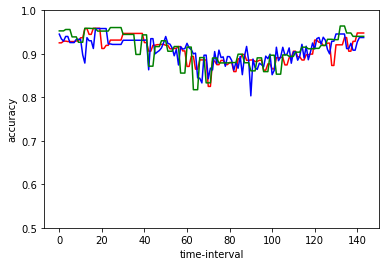

In [79]:
plt.xlabel('time-interval')
plt.ylabel('accuracy')
time = [i for i in range(144)]
plt.ylim(0.5, 1)
plt.plot(time, plt20_min_to_10, "r")
plt.plot(time, plt10_min_to_10, "b")
plt.plot(time, plt30_min_to_10, "g")
plt.savefig("different_tau_values.svg", format="svg")
plt.savefig("different_tau_values.pdf", format="pdf")
plt.show()

In [104]:
test35percent = [0.988, 0.9873, 0.987, 0.9624, 0.944, 0.9883, 0.988, 0.992, 0.9897, 0.9888, 0.986, 0.986, 0.9453, 0.988, 0.951, 0.8647, 0.9688, 0.9634, 0.9697, 0.934, 0.9253, 0.928, 0.8975, 0.8525, 0.8896, 0.9463, 0.9043, 0.8804, 0.918, 0.9126, 0.932, 0.8955, 0.923, 0.8916, 0.945, 0.9653, 0.9688, 0.9595, 0.969, 0.9253, 0.977, 0.9727, 0.9824, 0.9785, 0.988, 0.966, 0.9863, 0.987]

In [103]:
max(test35percent)

9126

In [99]:
name = "/home/sepehr/thesis/APDataML/6class_LR_noPenalty_normal.pickle"
with open(name, 'rb') as handle:
    plt30 = pickle.load(handle)   
test25_10precent = plt30["accuracy"].tolist()

In [95]:
name = "/home/sepehr/thesis/APDataML/result_25Only_5class_DataFrameNoPenalty.pickle"
with open(name, 'rb') as handle:
    plt30 = pickle.load(handle)
test25precent = plt30["accuracy"].tolist()

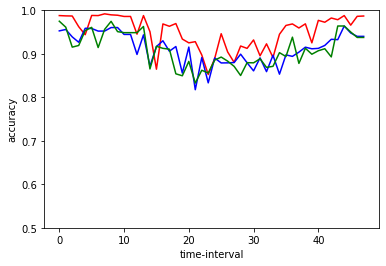

In [109]:
plt.xlabel('time-interval')
plt.ylabel('accuracy')
time = [i for i in range(48)]
plt.ylim(0.5, 1)
plt.plot(time, test35percent, "r")
plt.plot(time, test25_10precent, "b")
plt.plot(time, test25precent, "g")
plt.savefig("constraints_diff.svg", format="svg")
plt.savefig("constraints_diff.pdf", format="pdf")
plt.show()